In [1]:
# Visualization of activity difference between a classical neural network and a FGnet
# shows that FGNs are trainable over multiple layers
# shows that FGNs have less linear seperation of space

# this notebook showcases classic linear+tanh feedforward nets and full FGN nets

# you can try various: Network sizes, dropout probs, lambdas in the losses, different 2d data sets

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets as skdatasets
from sklearn.utils import shuffle as shuffle_in_unison


import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

crescent  Thu Sep 12 19:37:20 2019
[0] GeForce GTX 1080 | 58'C,   0 % |  4229 /  8119 MB | salami(2935M) felix(669M) felix(615M)
[1] GeForce GTX 1080 | 72'C, 100 % |  7327 /  8119 MB | soumi(7317M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)


# manualy set cuda device
torch.cuda.set_device(0)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
num_classes = 5
total_num_samples = 2048*num_classes

# random blobs
samples, labels = skdatasets.make_blobs(n_features=2, n_samples=total_num_samples, centers=num_classes, shuffle=True)
# train/test split
ratio=4.0/5.0
split_index = int(len(samples)*ratio)

train_samples, train_labels = samples[:split_index], labels[:split_index]
test_samples, test_labels = samples[split_index:], labels[split_index:]

num_samples = len(train_samples)

<IPython.core.display.Javascript object>


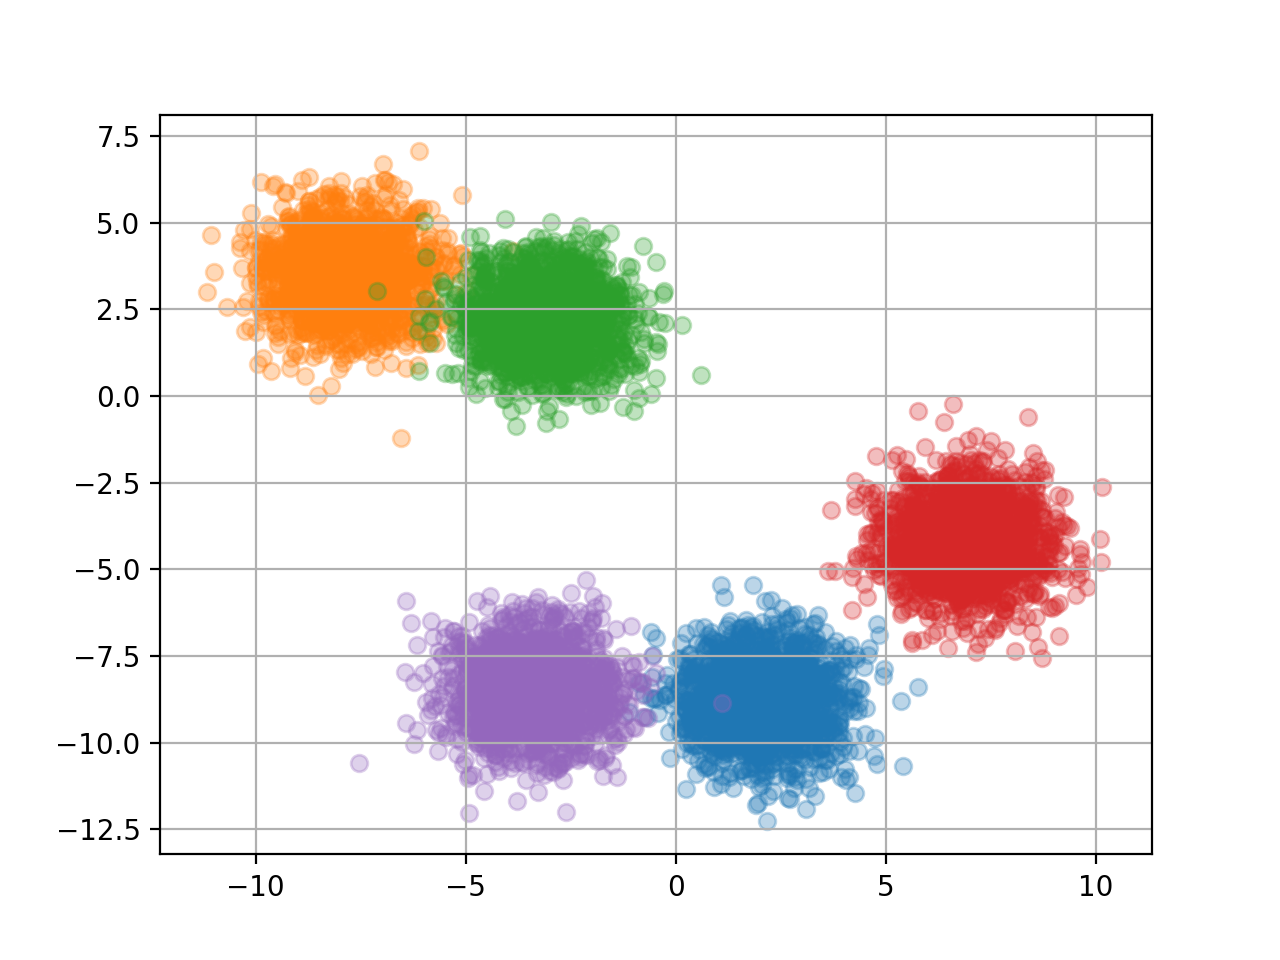

In [9]:
# 2D Check 
for label in range(num_classes):
    samples_x = [x for x,l in zip(train_samples[:,0], train_labels) if l==label]
    samples_y = [y for y,l in zip(train_samples[:,1], train_labels) if l==label]
    plt.scatter(samples_x, samples_y, alpha=0.3)


plt.grid(True)
plt.show()

In [10]:
# convert data to pytorch format 
tensor_train_x = torch.Tensor(train_samples)
tensor_train_y = torch.Tensor(train_labels)

tensor_test_x = torch.Tensor(test_samples)
tensor_test_y = torch.Tensor(test_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_train_x, tensor_train_y) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_test_x,tensor_test_y) # create your dataset

batch_size = 192
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data, shuffle=True) # create your dataloader

In [11]:
### PART 1: classic feedforward net (linear with bias + tanh)

In [12]:
# loss functions for the classic net
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda_l2)
      
classical_cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)

4.8828125e-05


In [13]:
# Initialize the classic network
hidden_layer_sizes = [10,10]
drop_p = 0.

In [14]:
classic_model = fgnl.Feedforward_Classic_net(in_feats=2, out_feats=num_classes, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p).to(device)

In [15]:
# define model params to optimize
classic_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, classic_model.parameters()),momentum=0.5)

In [16]:
epochs = 5

In [17]:
# train the network for N epochs
print("# epochs:", epochs)
classic_train_res = fgnh.train(classic_model, my_dataloader, 
                             classical_cross_ent_loss, classic_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

# epochs: 5
Epoch 0 Train set - Average loss: 0.2223, Accuracy: 7685/8192 (94%)
Test set - Average loss: 0.1465, Accuracy: 1925/2048 (94%)
Epoch 1 Train set - Average loss: 0.0385, Accuracy: 8094/8192 (99%)
Test set - Average loss: 0.0925, Accuracy: 1973/2048 (96%)
Epoch 2 Train set - Average loss: 0.0318, Accuracy: 8114/8192 (99%)
Test set - Average loss: 0.0595, Accuracy: 1993/2048 (97%)
Epoch 3 Train set - Average loss: 0.0329, Accuracy: 8099/8192 (99%)
Test set - Average loss: 0.1597, Accuracy: 1930/2048 (94%)
Epoch 4 Train set - Average loss: 0.0371, Accuracy: 8098/8192 (99%)
Test set - Average loss: 0.1999, Accuracy: 1906/2048 (93%)


In [18]:
# test the statibility of the model (these numbers should be same as final lines above)
classic_test_res = fgnh.test(classic_model, my_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

classic_test_res = fgnh.test(classic_model, my_test_dataloader,
                        classical_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1796, Accuracy: 7687/8192 (94%)
Test set - Average loss: 0.1999, Accuracy: 1906/2048 (93%)


In [19]:
# scale of the heat maps
grid_max = 10.0*np.max(np.abs(samples))
print("grid range", grid_max)
X1 = np.arange(-grid_max, grid_max, grid_max/100.0)
X1s, X2s = np.meshgrid(X1,X1)
heatmap_inputs = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))
print("shape of heatmap", np.shape(heatmap_inputs))
heatmap_inputs = torch.Tensor(heatmap_inputs)
print(type(heatmap_inputs))
# print(heatmap_inputs)

grid range 122.4733909862074
shape of heatmap (40000, 2)
<class 'torch.Tensor'>


In [20]:
# compute predictions for heatmap
classic_model.eval()
classic_heatmap_preds = classic_model(heatmap_inputs.to(device))
classic_heatmap_preds = classic_heatmap_preds.cpu().detach().numpy()
# make sure we arent out of range for softmax exp
classic_heatmap_preds = np.clip(classic_heatmap_preds, a_max=71, a_min=-71)
# apply softmax for probs
classic_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in classic_heatmap_preds])

<IPython.core.display.Javascript object>


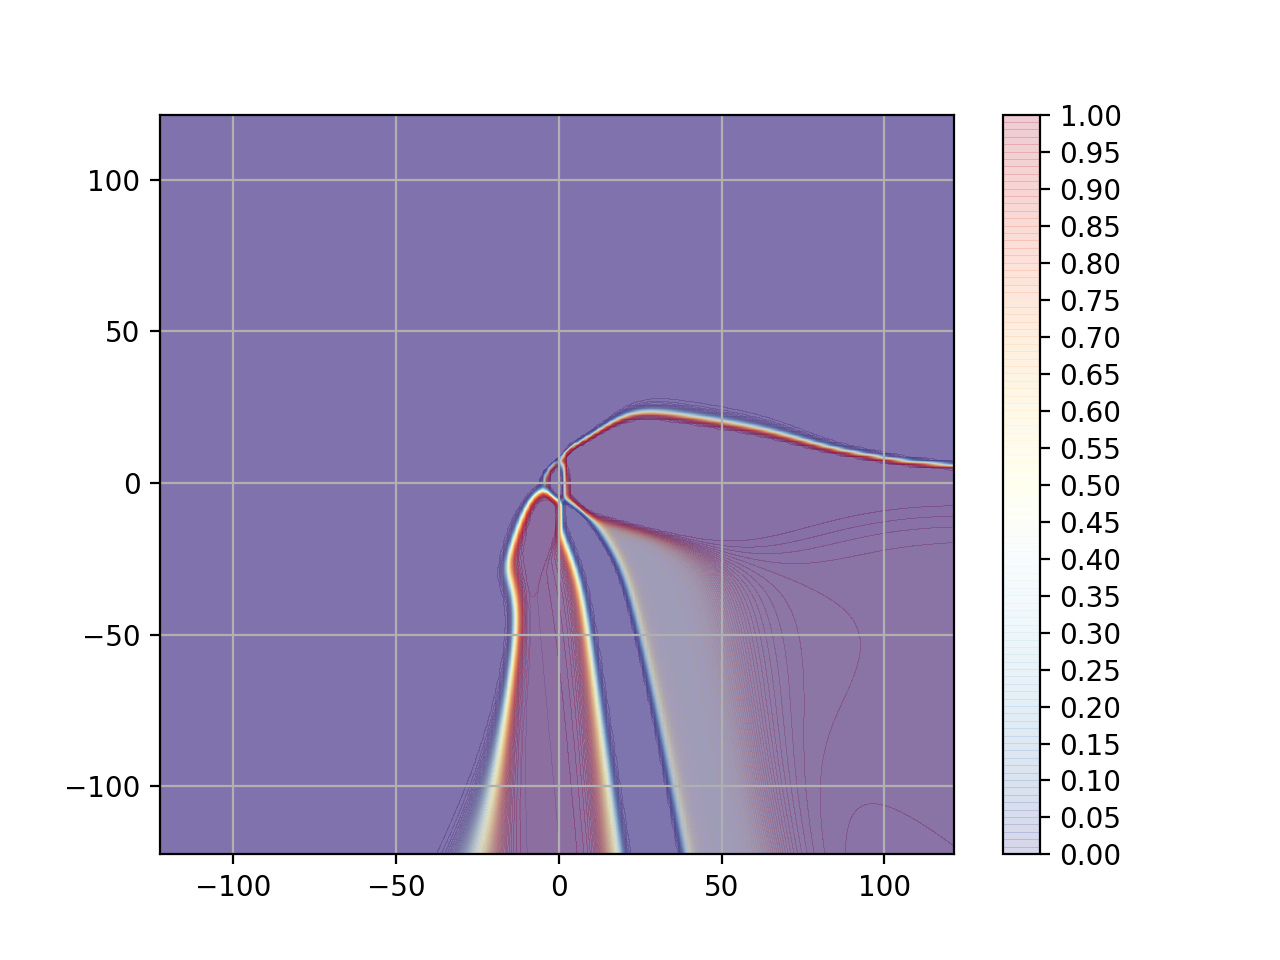

In [21]:
# plot the stacked heatmaps
levels = np.arange(-0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(classic_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r, alpha=1.0/num_classes)
plt.colorbar(ticks=ticks)

plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


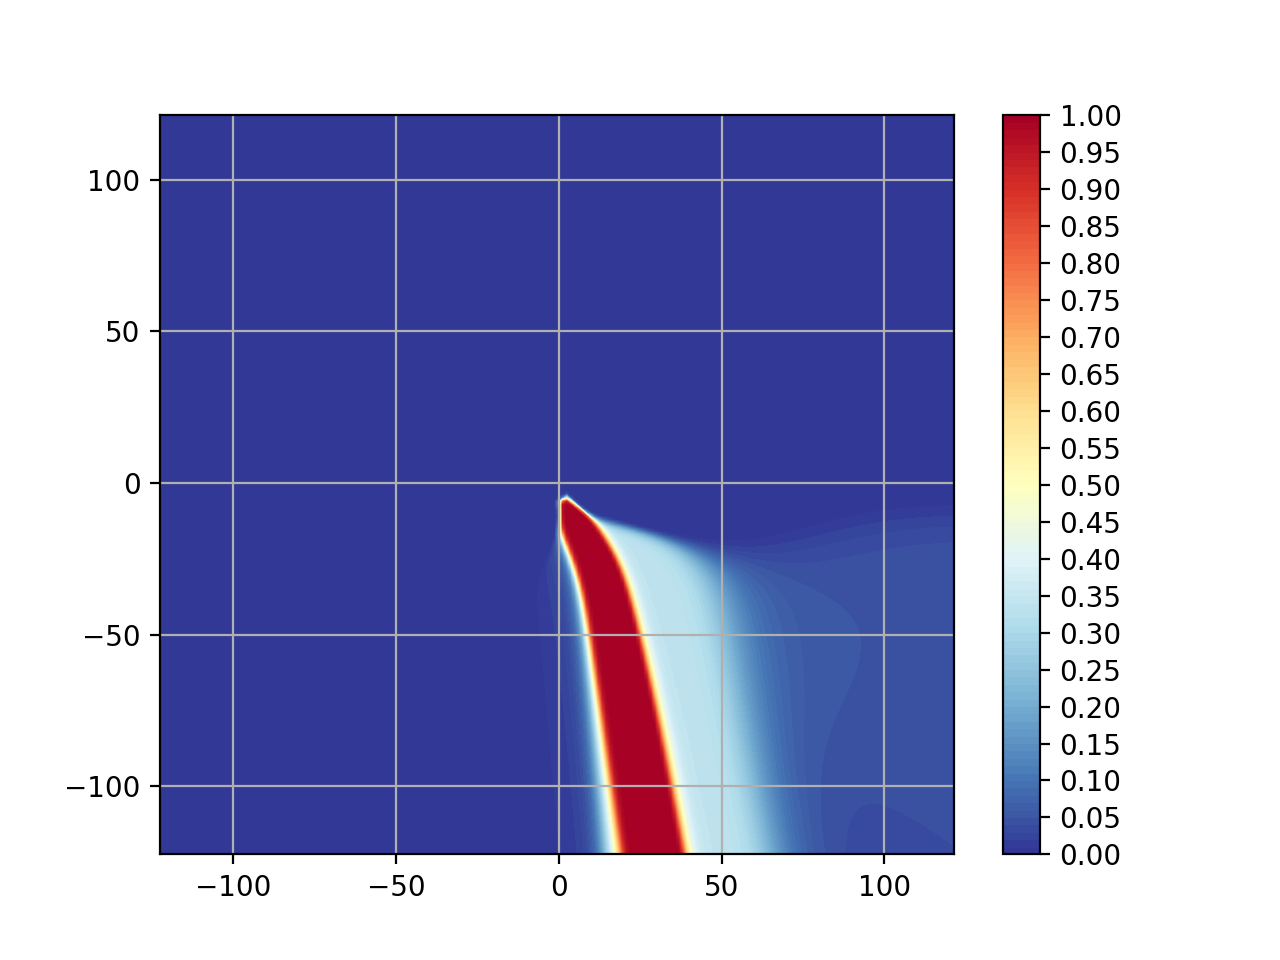

<IPython.core.display.Javascript object>


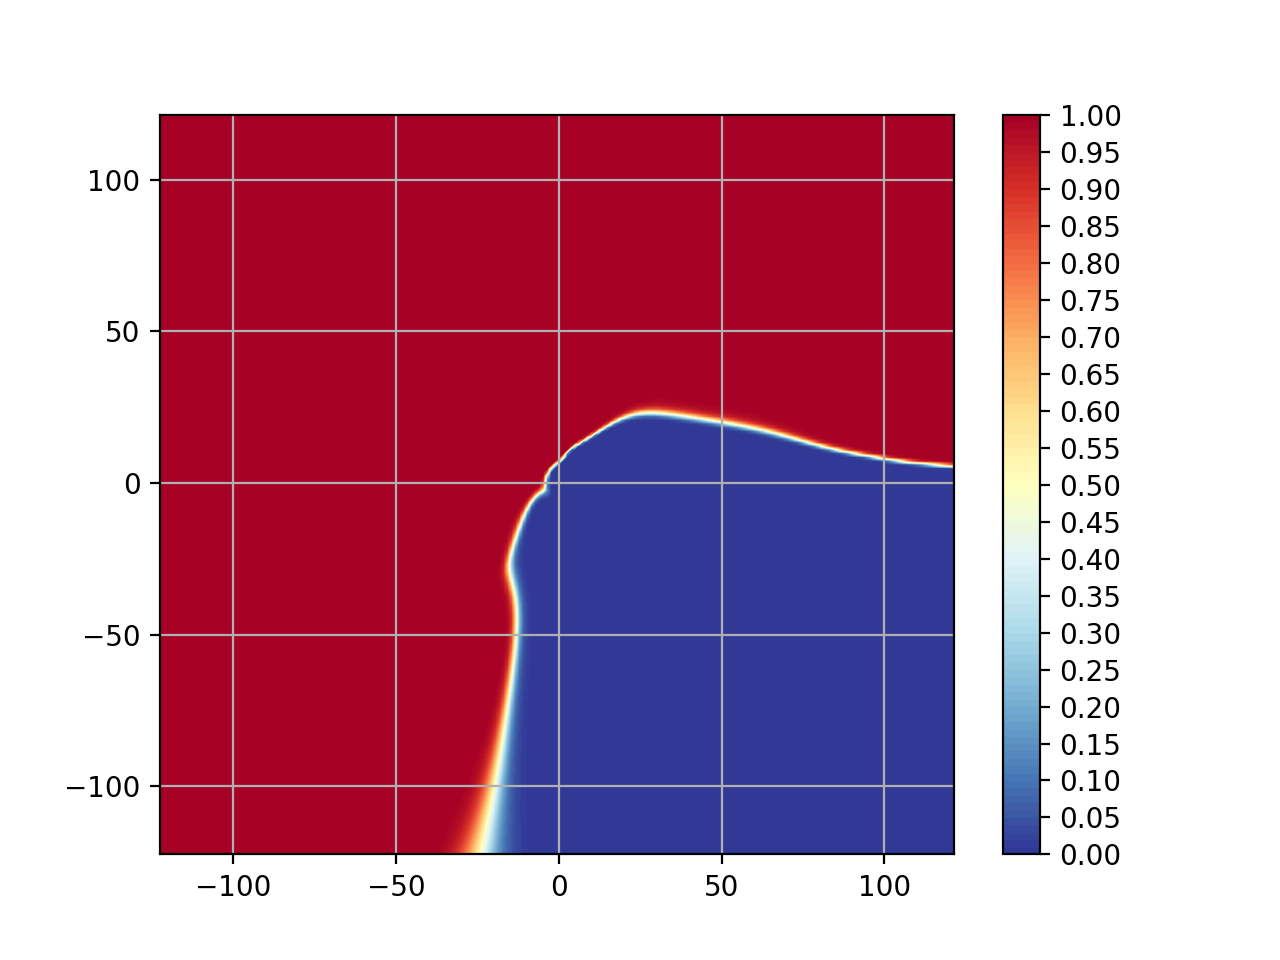

<IPython.core.display.Javascript object>


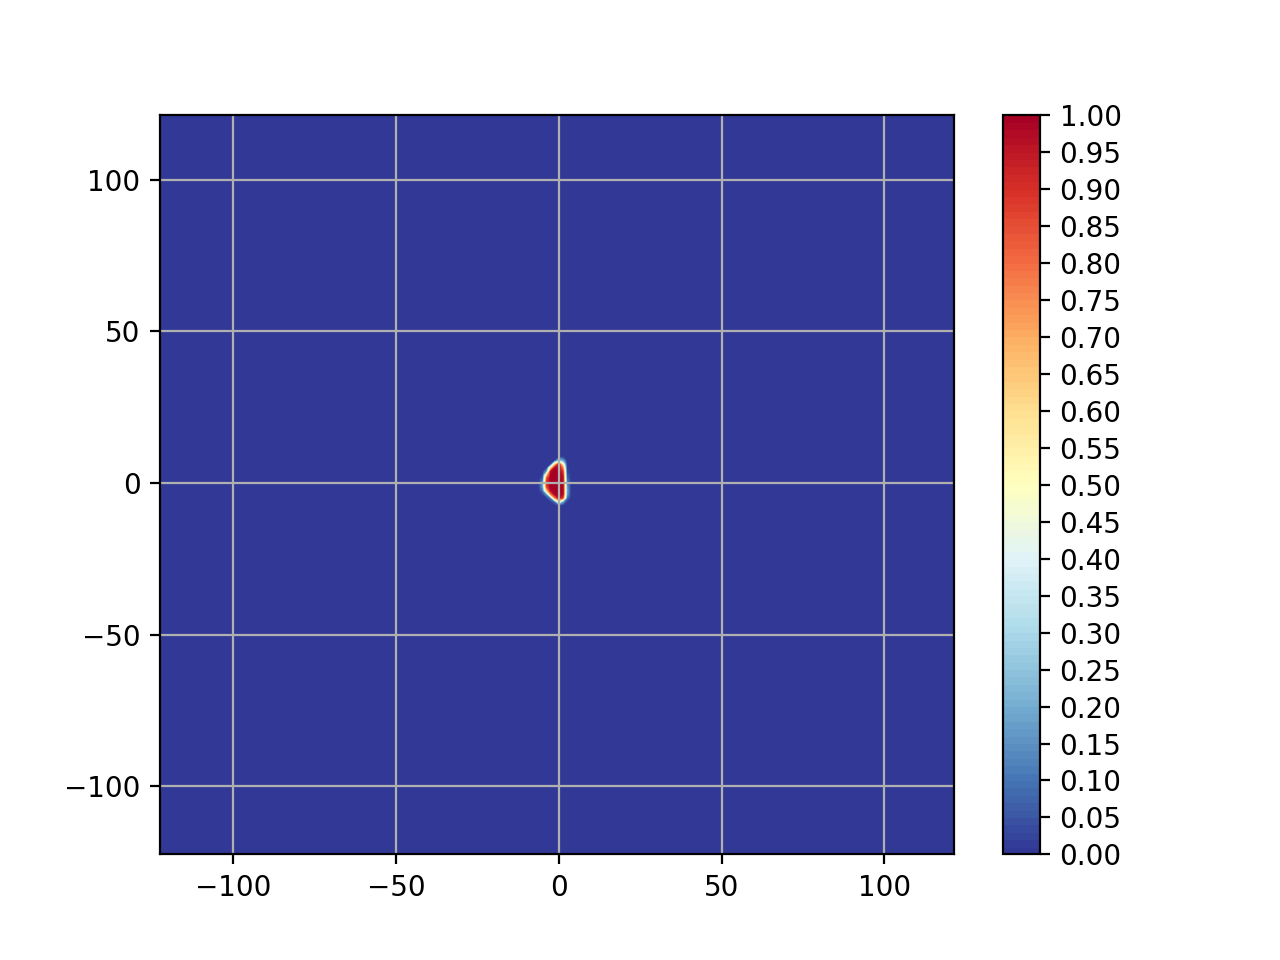

<IPython.core.display.Javascript object>


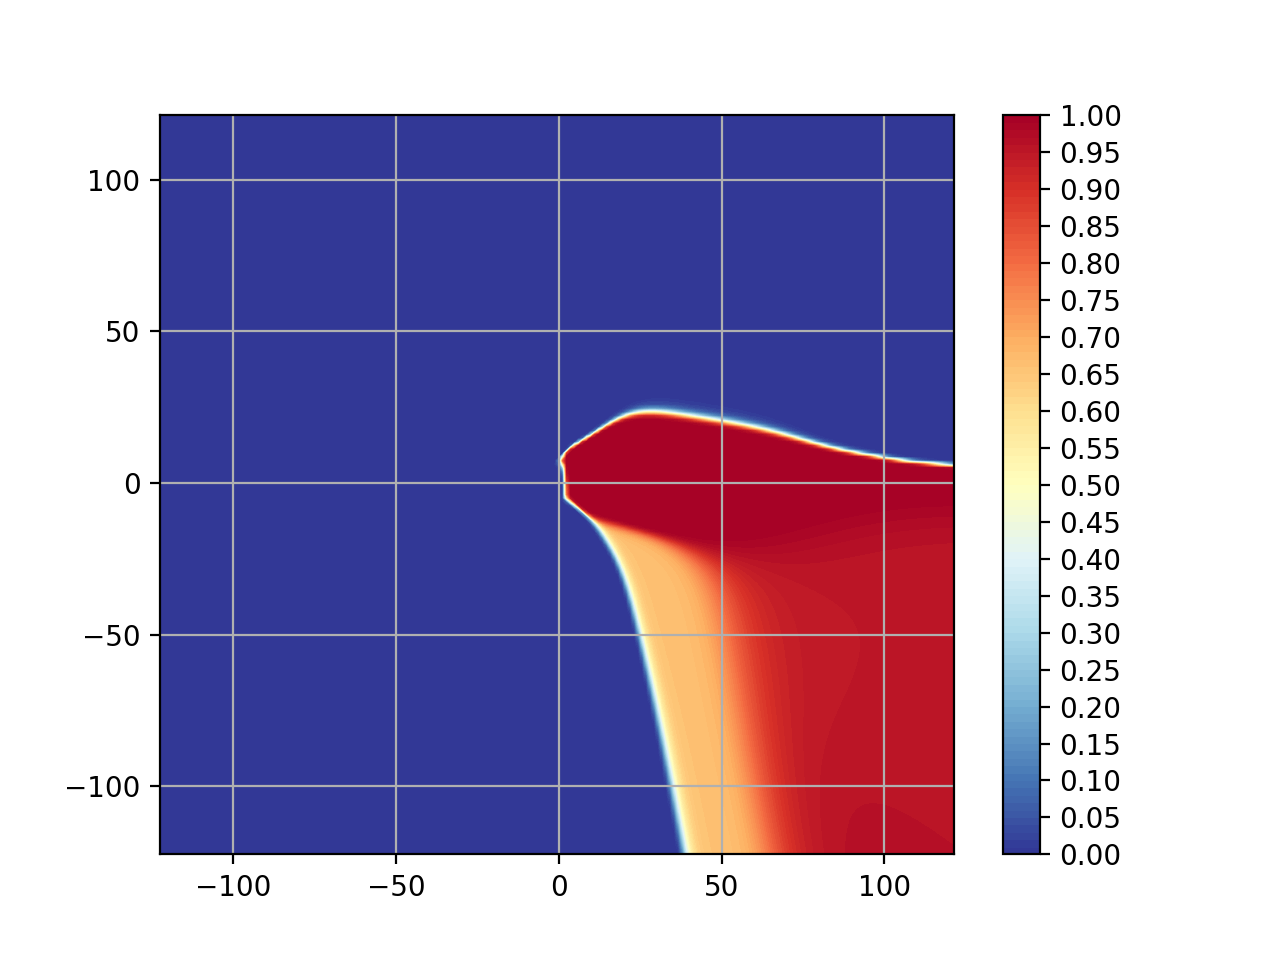

<IPython.core.display.Javascript object>


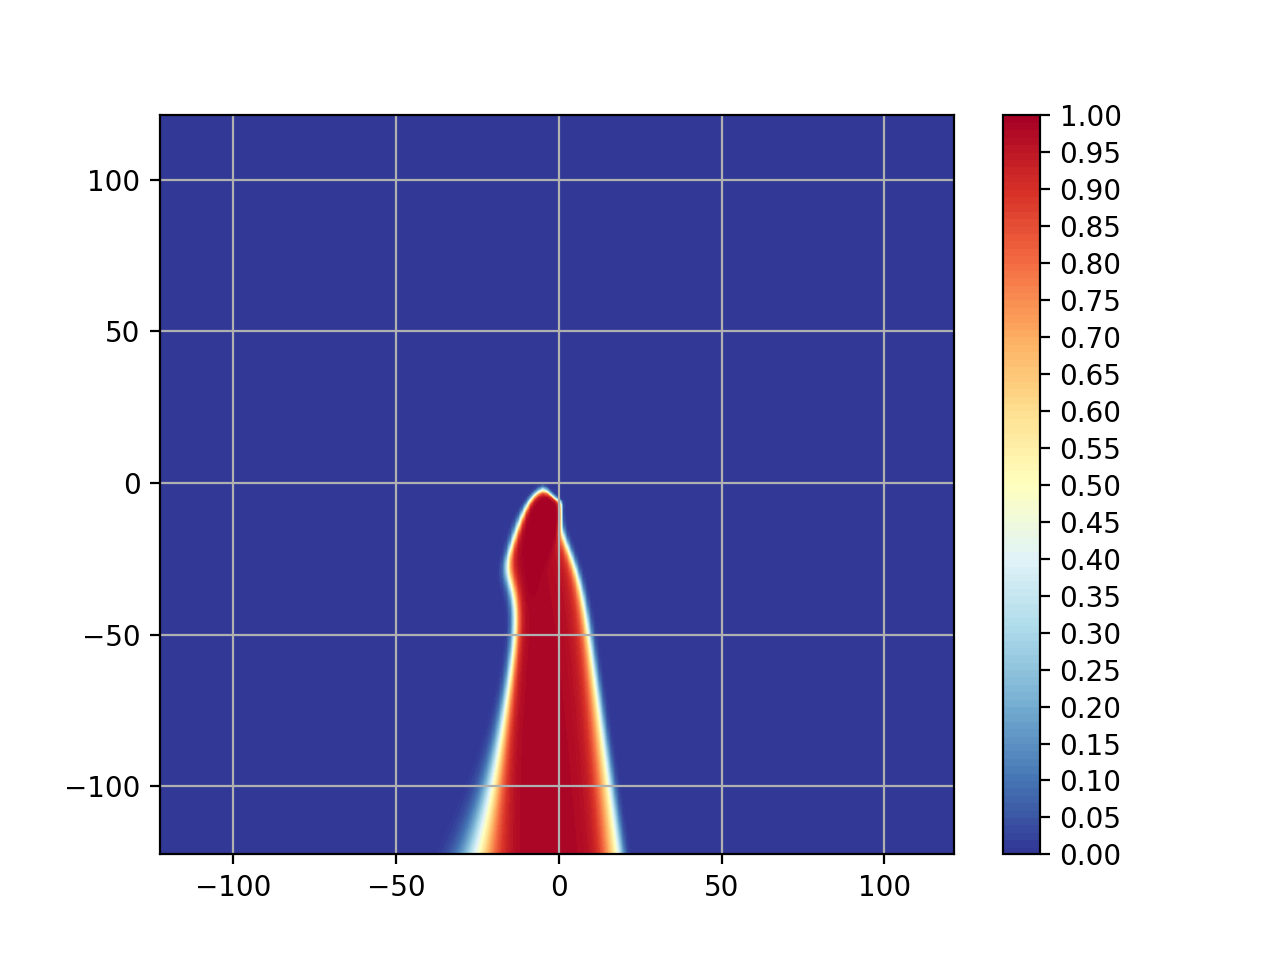

In [22]:
# plot the heatmaps individually 
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(classic_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
    plt.colorbar(ticks=ticks)
    plt.grid(True)
    plt.show()

# plt.colorbar(ticks=ticks)
# plt.grid(True)
# plt.show()

In [23]:
### PART 2: fully FGN network

In [24]:
### Loss Functions for the FGN

# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 1.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

fgn_cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

lambda for l2 loss 4.8828125e-05
lambda for sigs^2 loss 4.8828125e-05


In [25]:
# fgn specific params
print("hidden_layer_sizes:", hidden_layer_sizes)
covar_type = 'full'
print("covariance:", covar_type)
ordinal = float(2)
print("ordinal for norm:", ordinal)
non_lin = False
print("non linearity", non_lin)
print("drop prob:", drop_p)
noisy_centers = False
print("noisy centers:", noisy_centers)
random_eval = False
print("Random Eval", random_eval)

# Initialize the fgn network
fgn_model = fgnl.Feedforward_FGN_net(in_feats=2, out_feats=num_classes, hidden_layer_sizes=hidden_layer_sizes, drop_p=drop_p,
                                     covar_type=covar_type, ordinal=ordinal, non_lin=non_lin, 
                                     noisy_centers=noisy_centers).to(device)

hidden_layer_sizes: [10, 10]
covariance: full
ordinal for norm: 2.0
non linearity False
drop prob: 0.0
noisy centers: False
Random Eval False


In [26]:
# define model params to optimize
fgn_optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, fgn_model.parameters()),momentum=0.5)

In [27]:
# train the network for N epochs
epochs = 5
print("num epochs", epochs)
fgn_train_res = fgnh.train(fgn_model, my_dataloader, 
                             fgn_cross_ent_loss, fgn_optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=my_test_dataloader)

num epochs 5
Epoch 0 Train set - Average loss: 0.7003, Accuracy: 5693/8192 (69%)
Test set - Average loss: 0.5668, Accuracy: 1561/2048 (76%)
Epoch 1 Train set - Average loss: 0.3331, Accuracy: 6450/8192 (79%)
Test set - Average loss: 0.2588, Accuracy: 1634/2048 (80%)
Epoch 2 Train set - Average loss: 0.2717, Accuracy: 6461/8192 (79%)
Test set - Average loss: 0.2481, Accuracy: 1632/2048 (80%)
Epoch 3 Train set - Average loss: 0.2675, Accuracy: 6471/8192 (79%)
Test set - Average loss: 0.2752, Accuracy: 1615/2048 (79%)
Epoch 4 Train set - Average loss: 0.1952, Accuracy: 6485/8192 (79%)
Test set - Average loss: 0.1672, Accuracy: 1623/2048 (79%)


In [28]:
# test the statibility of the model.
# (these numbers should be same as or close to final lines above, the smaller the batchsize the closer)

# set random eval to false to check 
fgn_model.set_random_eval(False)
fgn_test_res = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1735, Accuracy: 6485/8192 (79%)
Test set - Average loss: 0.1672, Accuracy: 1623/2048 (79%)


In [29]:
# change to random eval
fgn_model.set_random_eval(True)
fgn_test_res = fgnh.test(fgn_model, my_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

fgn_test_res = fgnh.test(fgn_model, my_test_dataloader,
                        fgn_cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.1735, Accuracy: 6485/8192 (79%)
Test set - Average loss: 0.1672, Accuracy: 1623/2048 (79%)


In [30]:
# plot heatmaps for random and non-random eval

In [31]:
# set eval to non-random
fgn_model.set_random_eval(False)

In [32]:
# compute predictions for heatmap
fgn_model = fgn_model.eval()
fgn_heatmap_preds = fgn_model(heatmap_inputs.to(device))
fgn_heatmap_preds = fgn_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in fgn_heatmap_preds.astype('float128')])

<IPython.core.display.Javascript object>


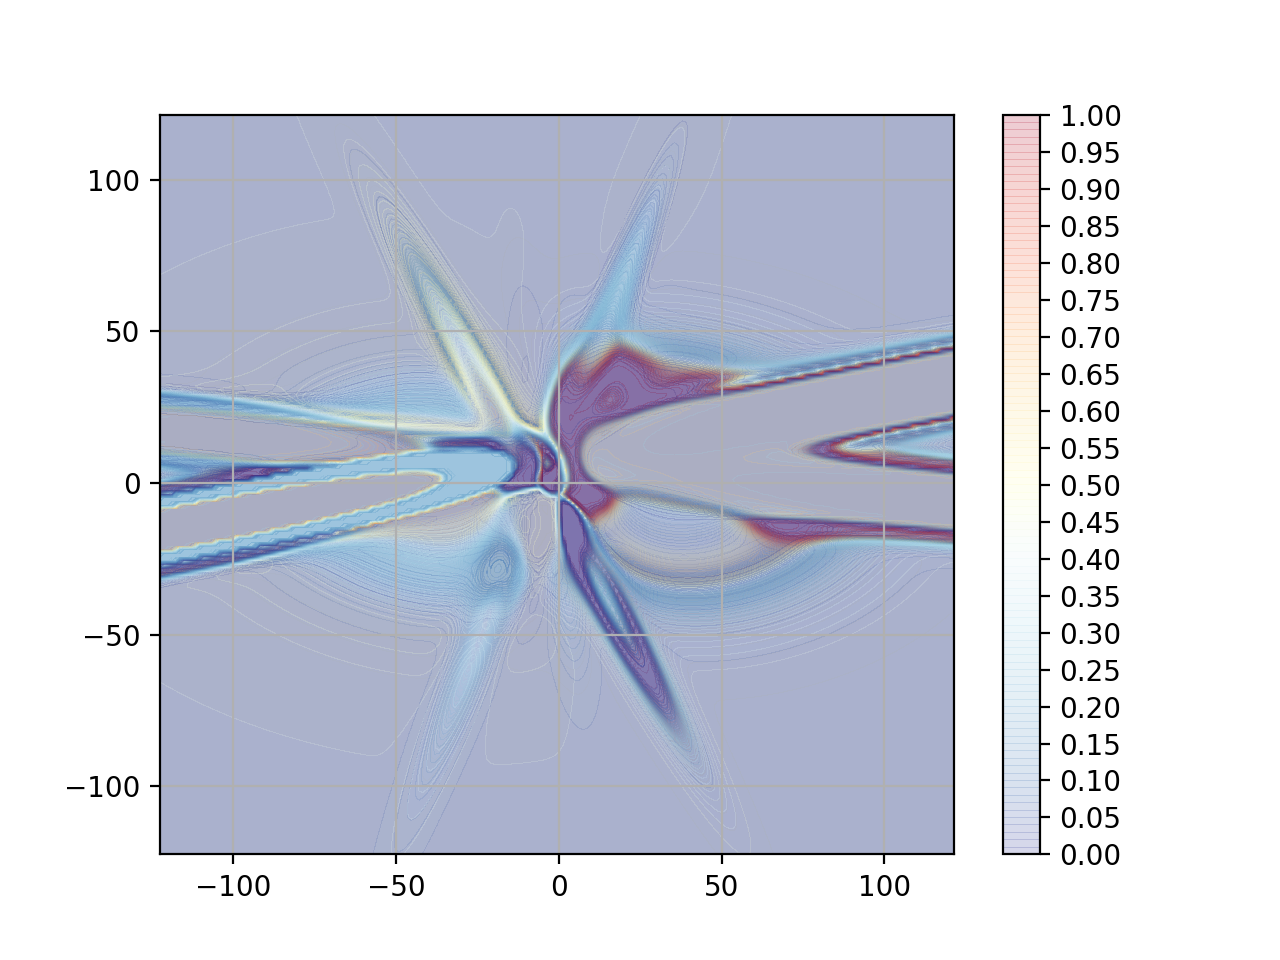

In [33]:
# plot the stacked heatmaps
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r, alpha=1.0/num_classes)

plt.colorbar(ticks=ticks)
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


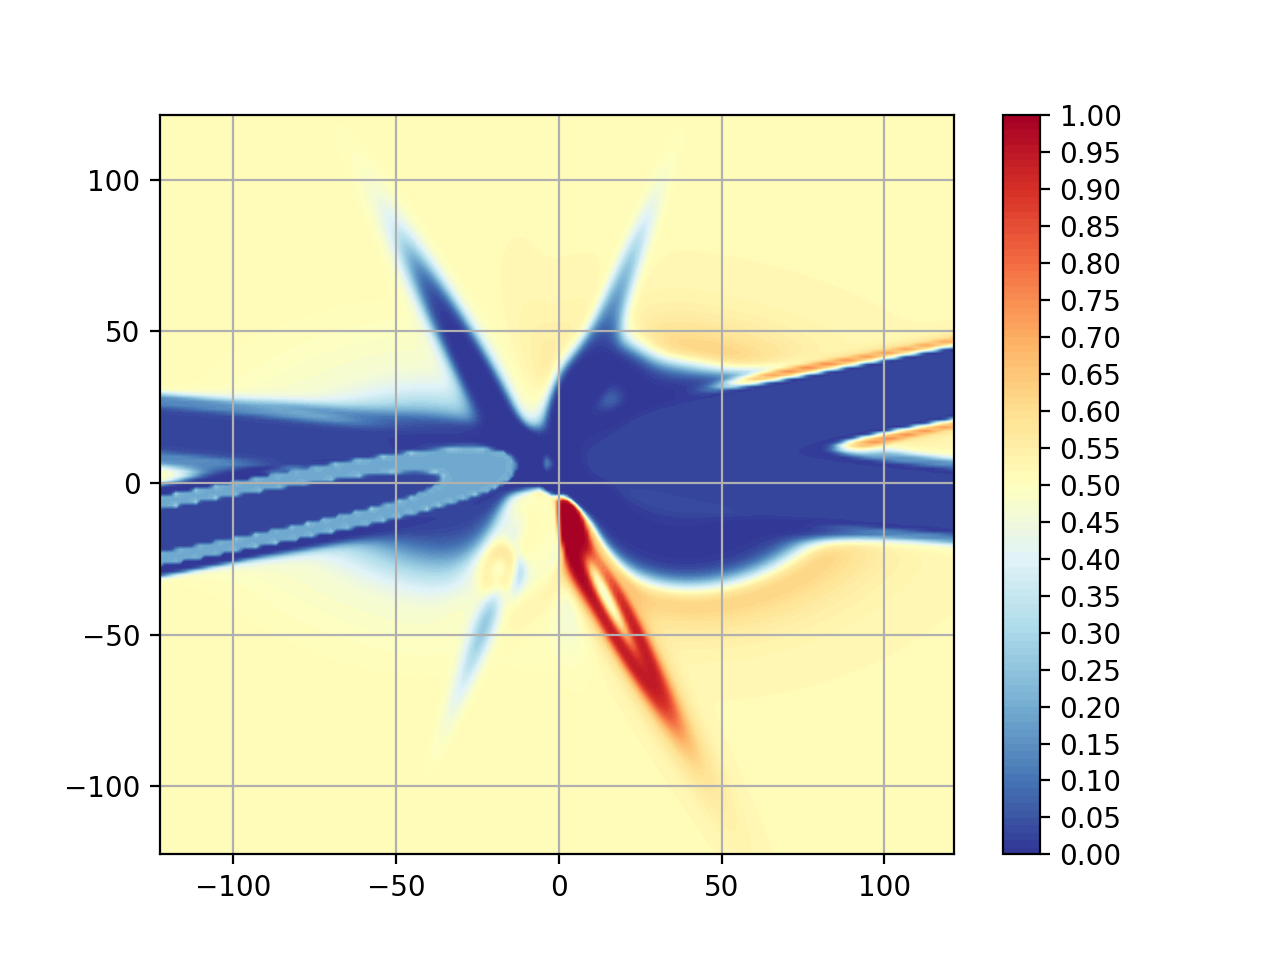

<IPython.core.display.Javascript object>


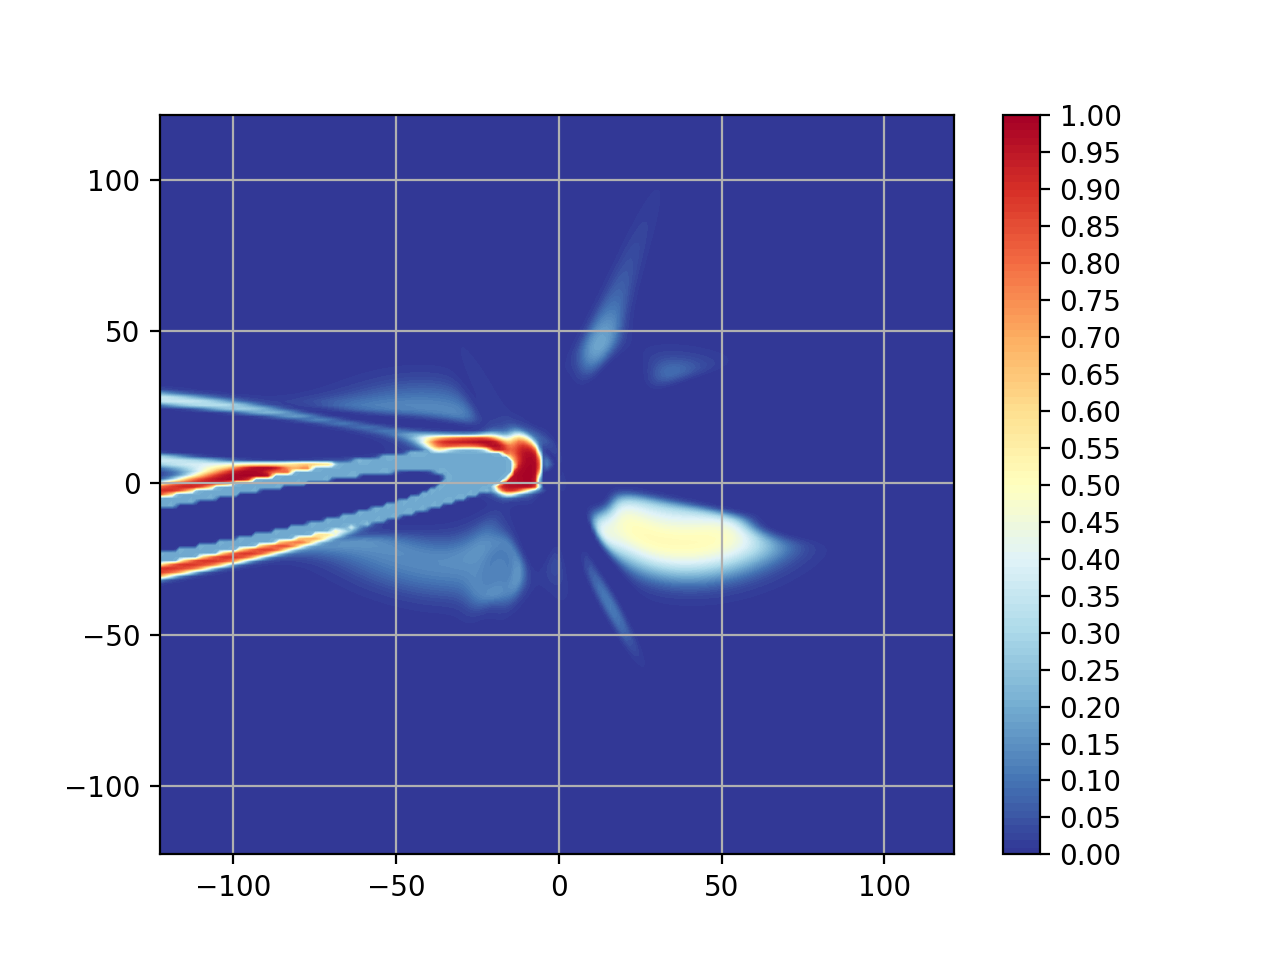

<IPython.core.display.Javascript object>


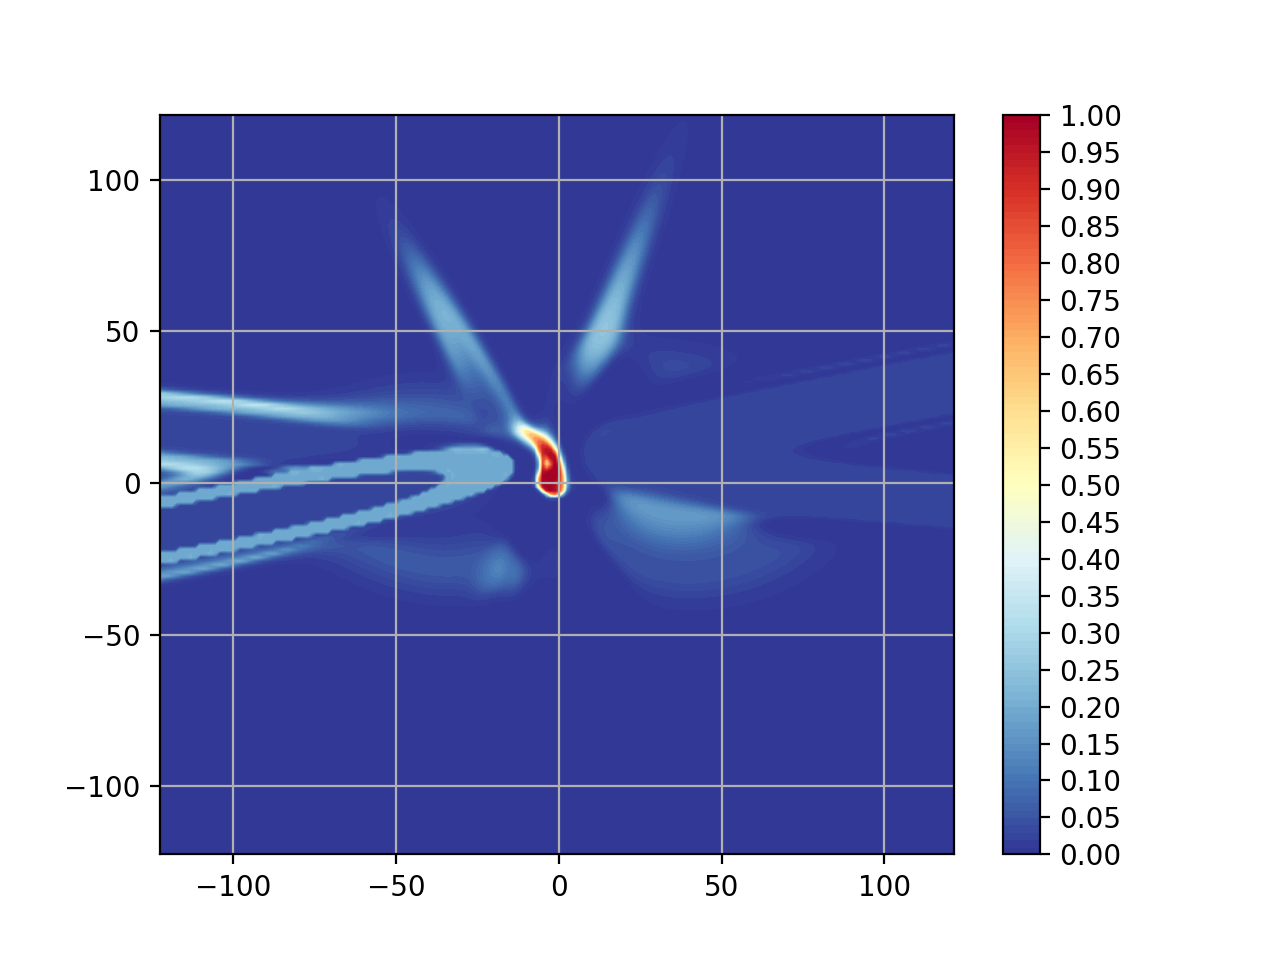

<IPython.core.display.Javascript object>


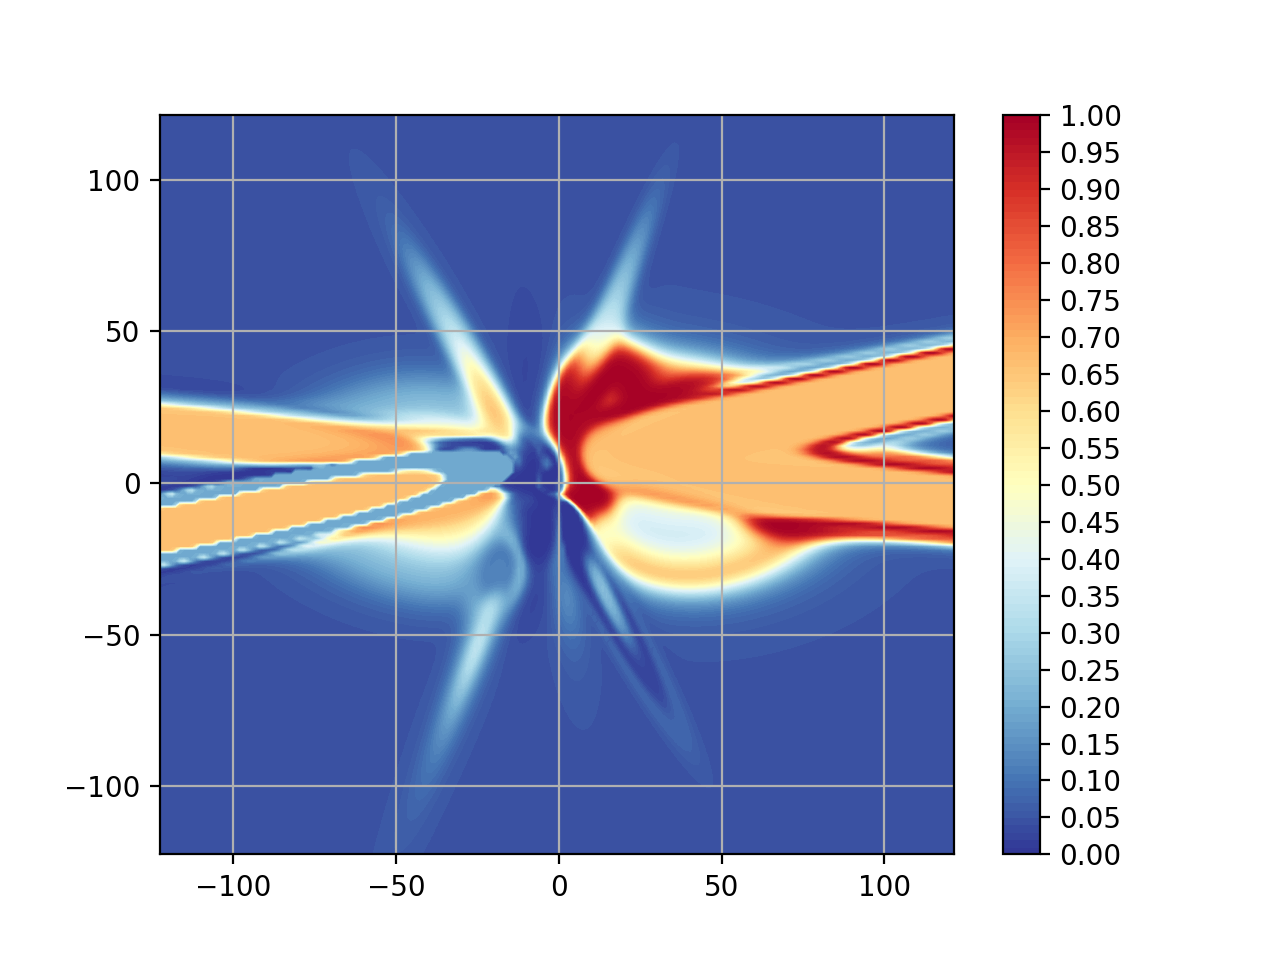

<IPython.core.display.Javascript object>


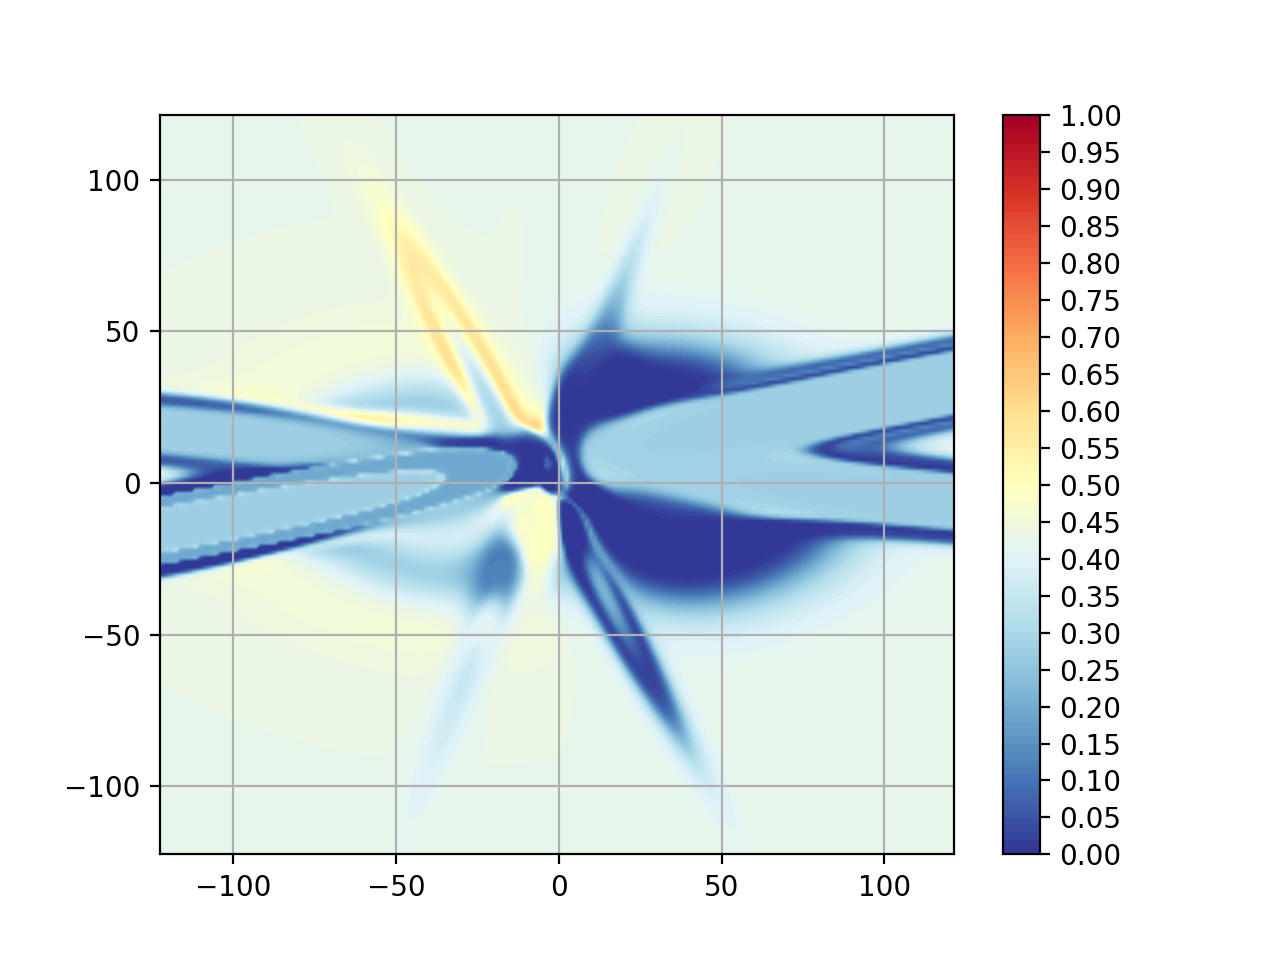

In [34]:
# plot the heatmaps individually
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
    plt.colorbar(ticks=ticks)
    plt.grid(True)
    plt.show()

In [35]:
# # set eval to non-random
fgn_model.set_random_eval(True)

In [36]:
# compute predictions for heatmap
fgn_model = fgn_model.eval()
fgn_heatmap_preds = fgn_model(heatmap_inputs.to(device))
fgn_heatmap_preds = fgn_heatmap_preds.cpu().detach().numpy()
# apply softmax for probs
fgn_heatmap_preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in fgn_heatmap_preds.astype('float128')])

<IPython.core.display.Javascript object>


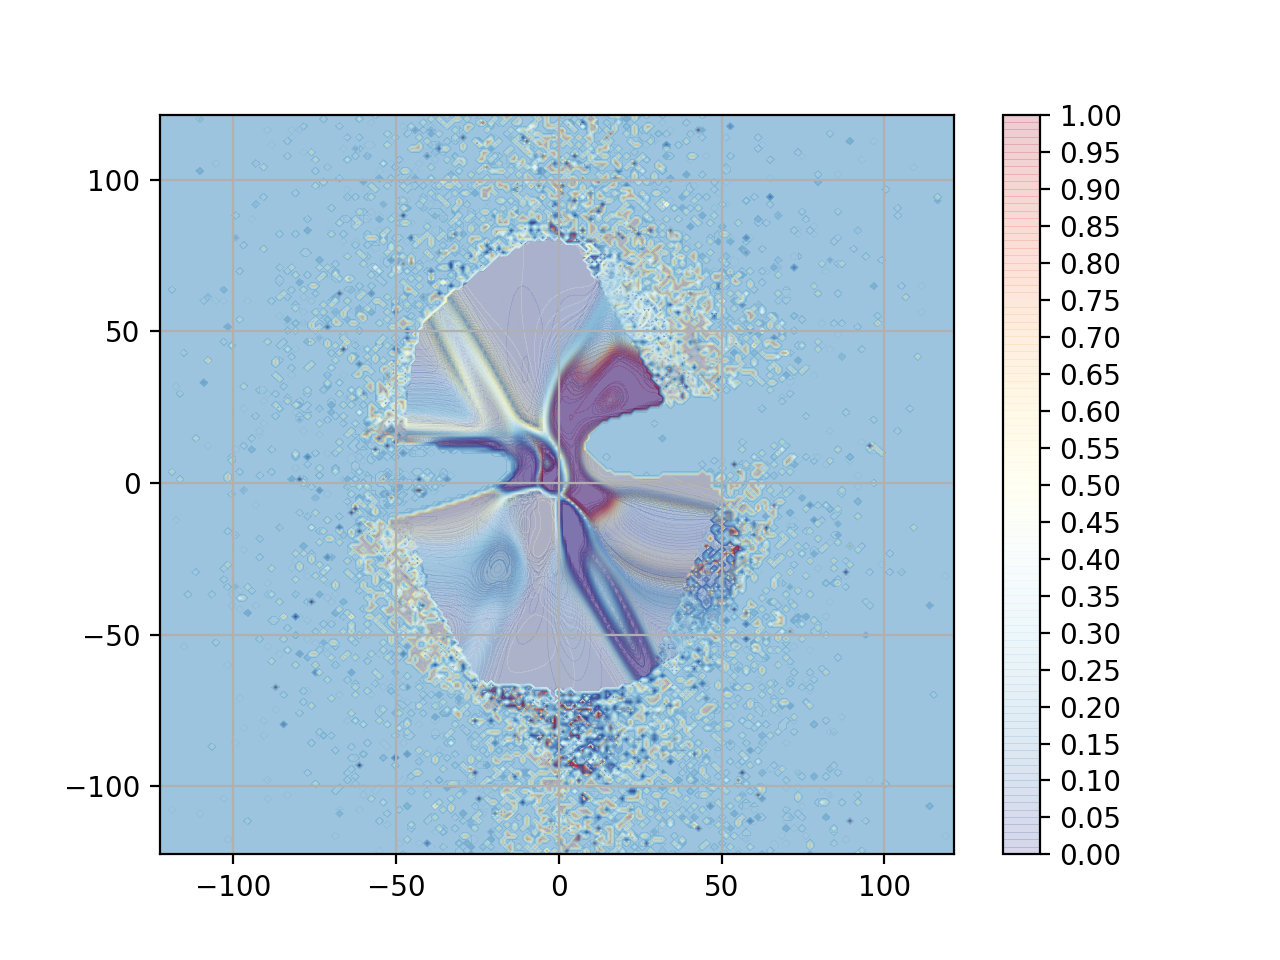

In [37]:
# plot the stacked heatmaps
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r, alpha=1.0/num_classes)

plt.colorbar(ticks=ticks)
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


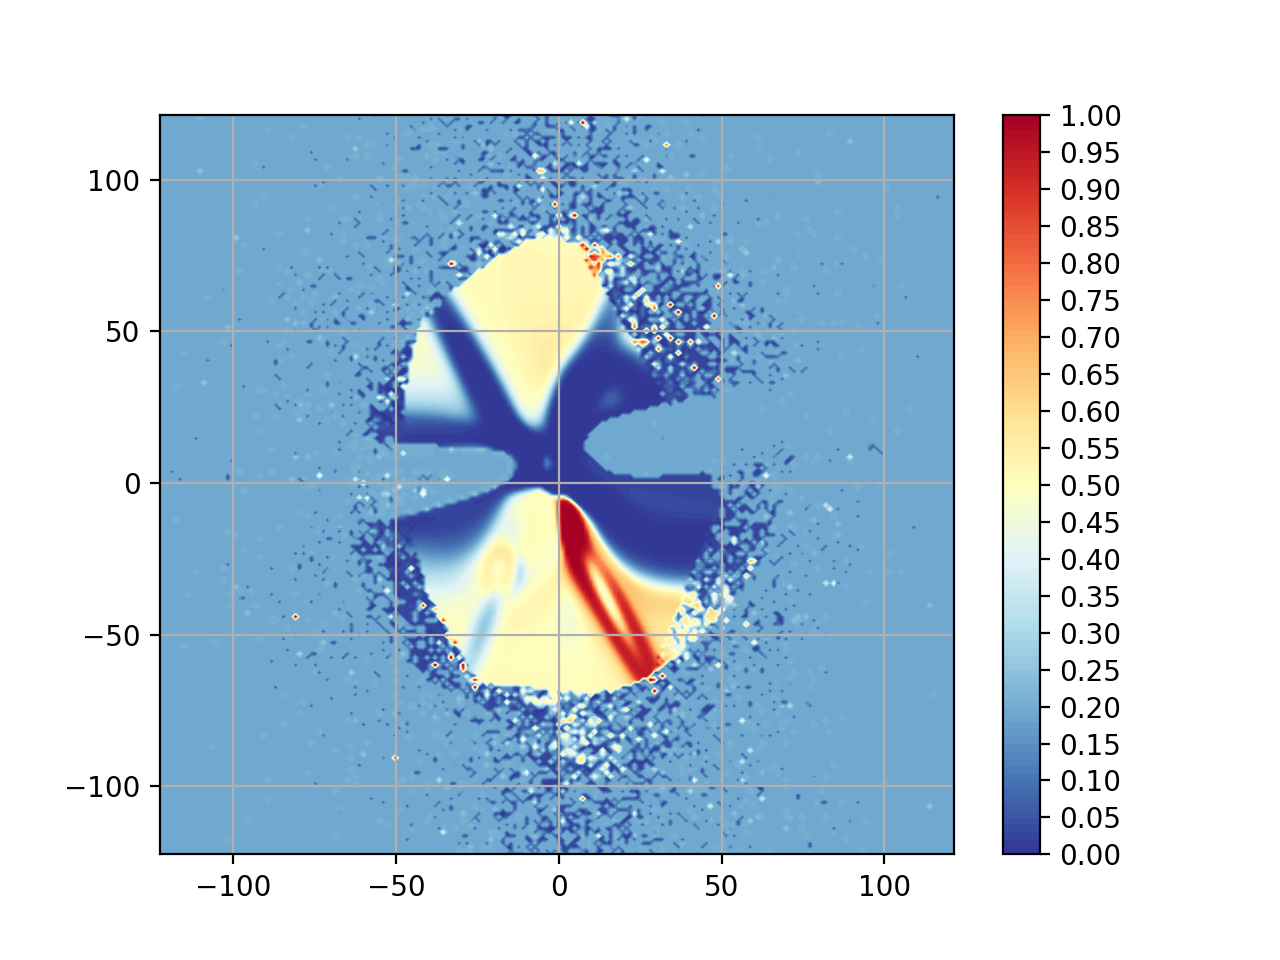

<IPython.core.display.Javascript object>


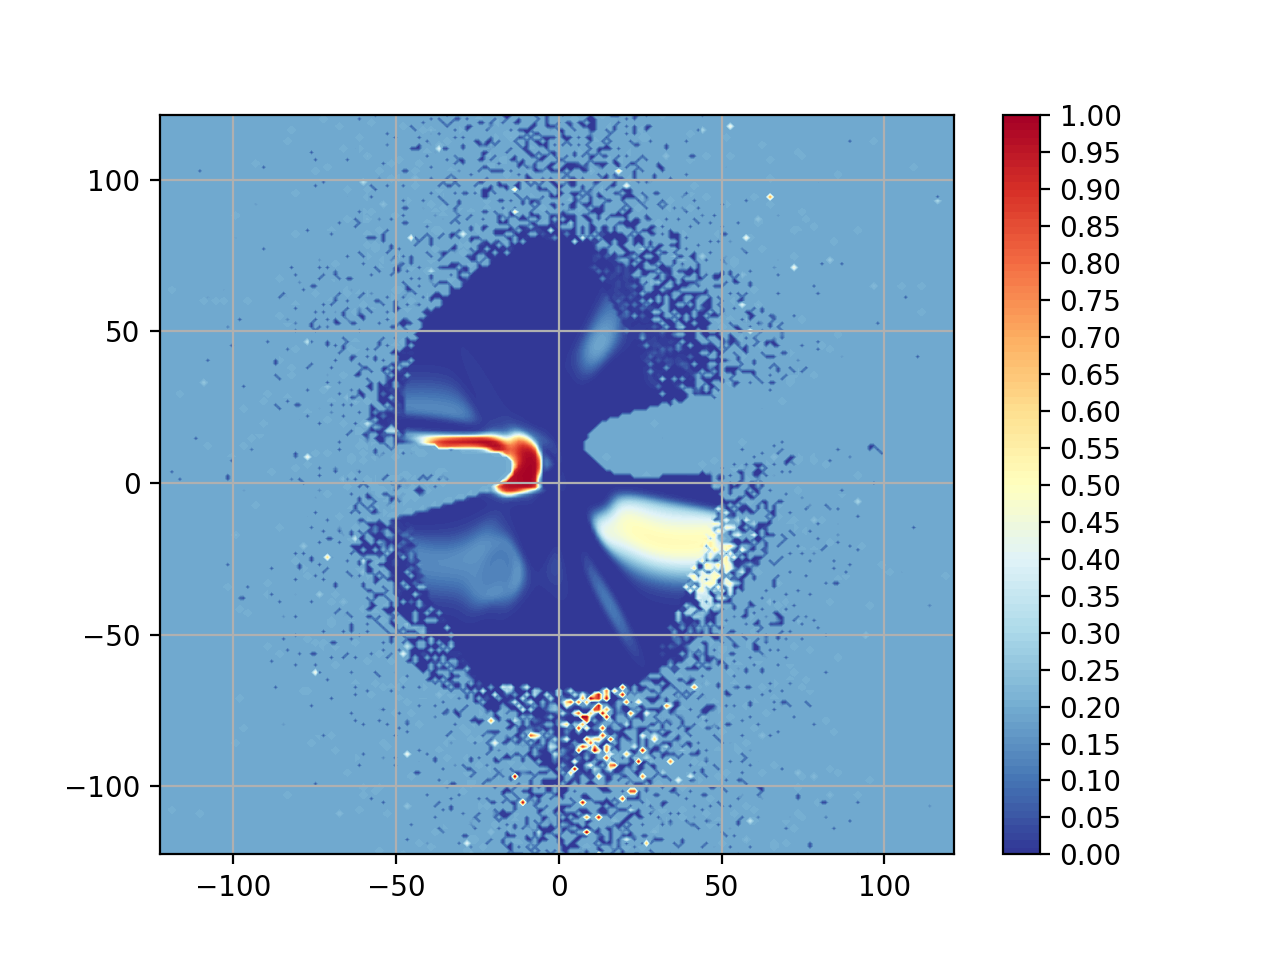

<IPython.core.display.Javascript object>


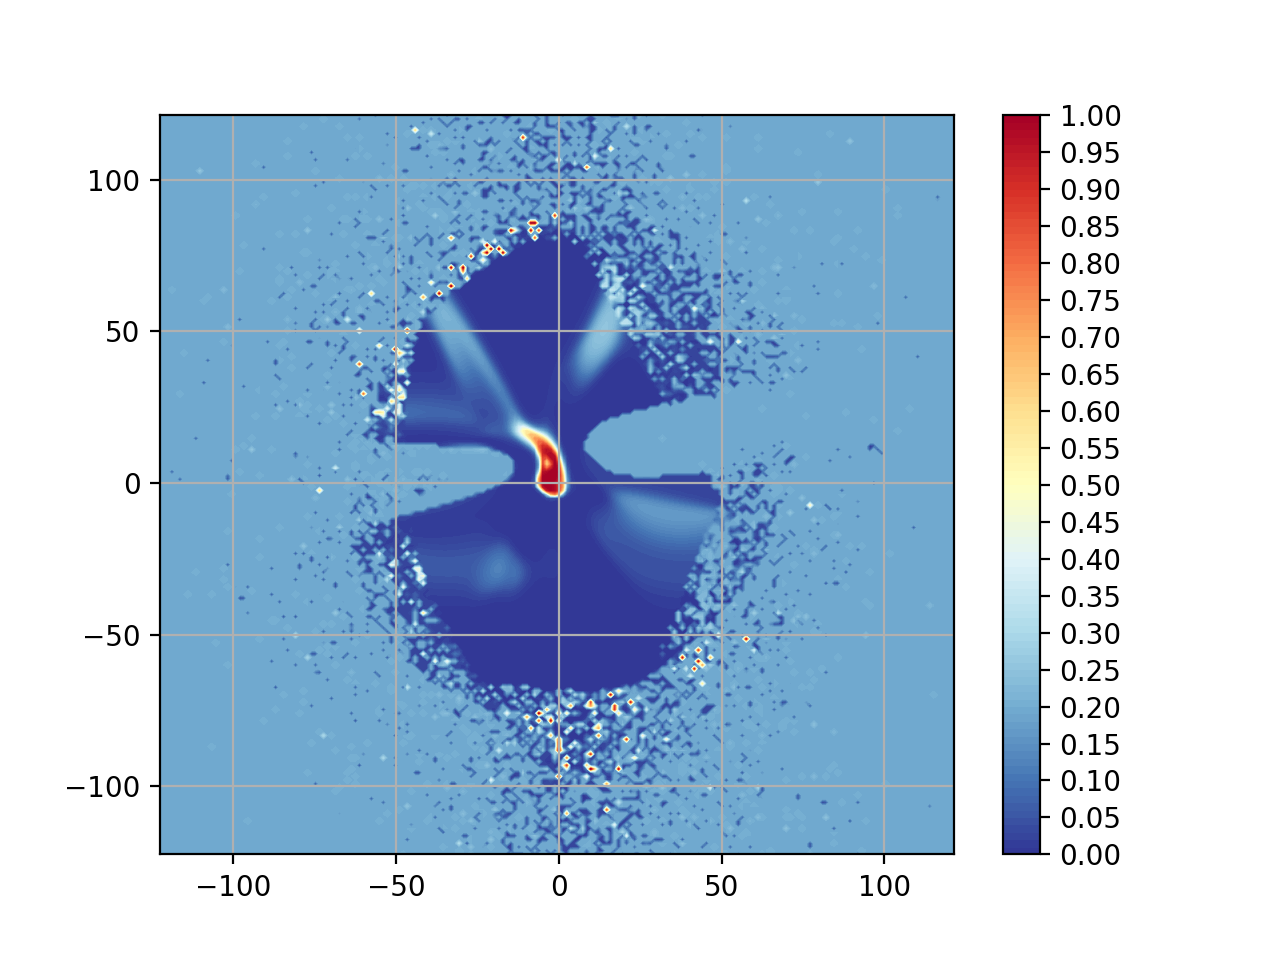

<IPython.core.display.Javascript object>


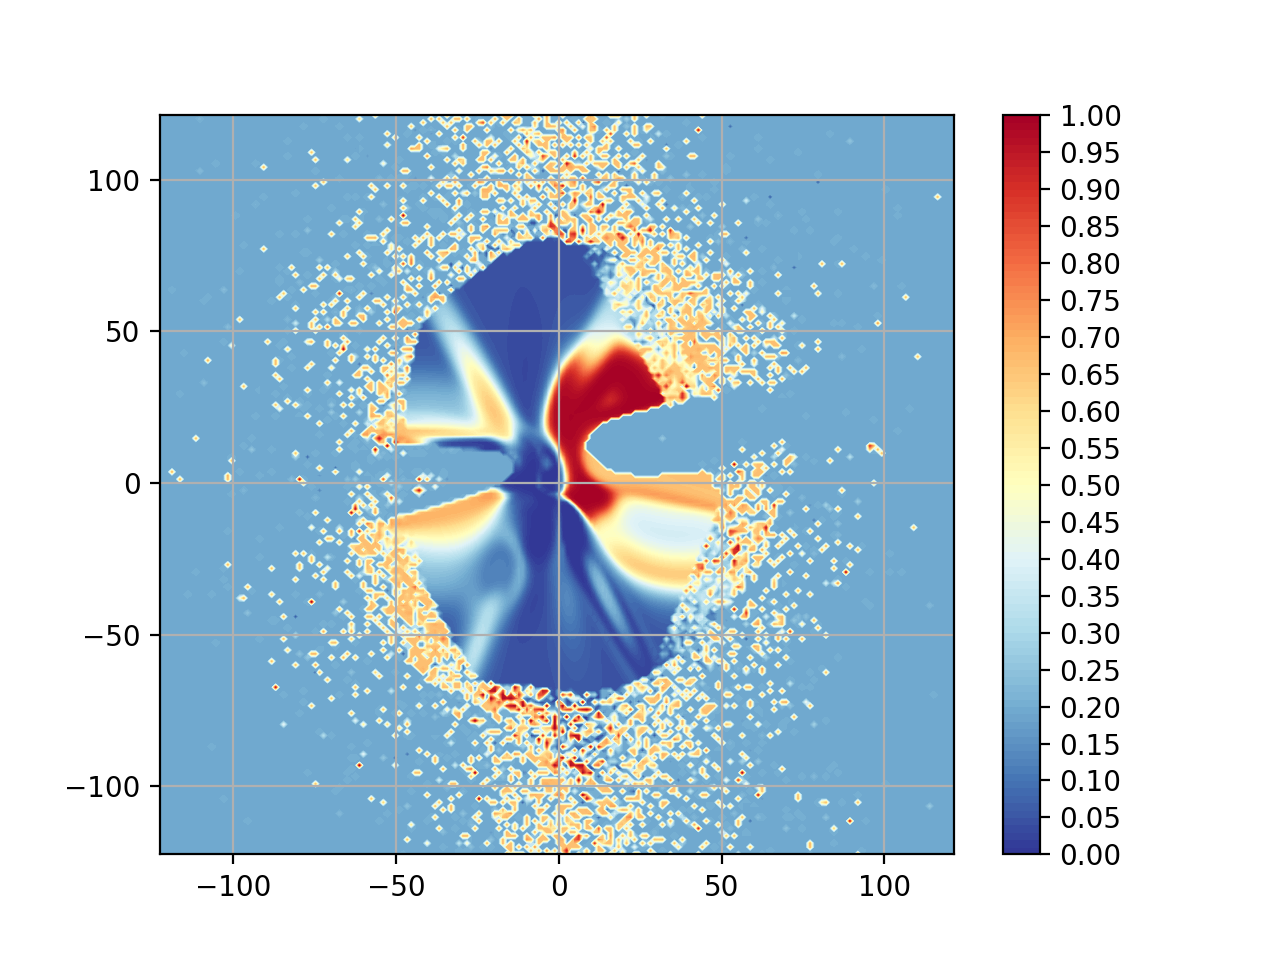

<IPython.core.display.Javascript object>


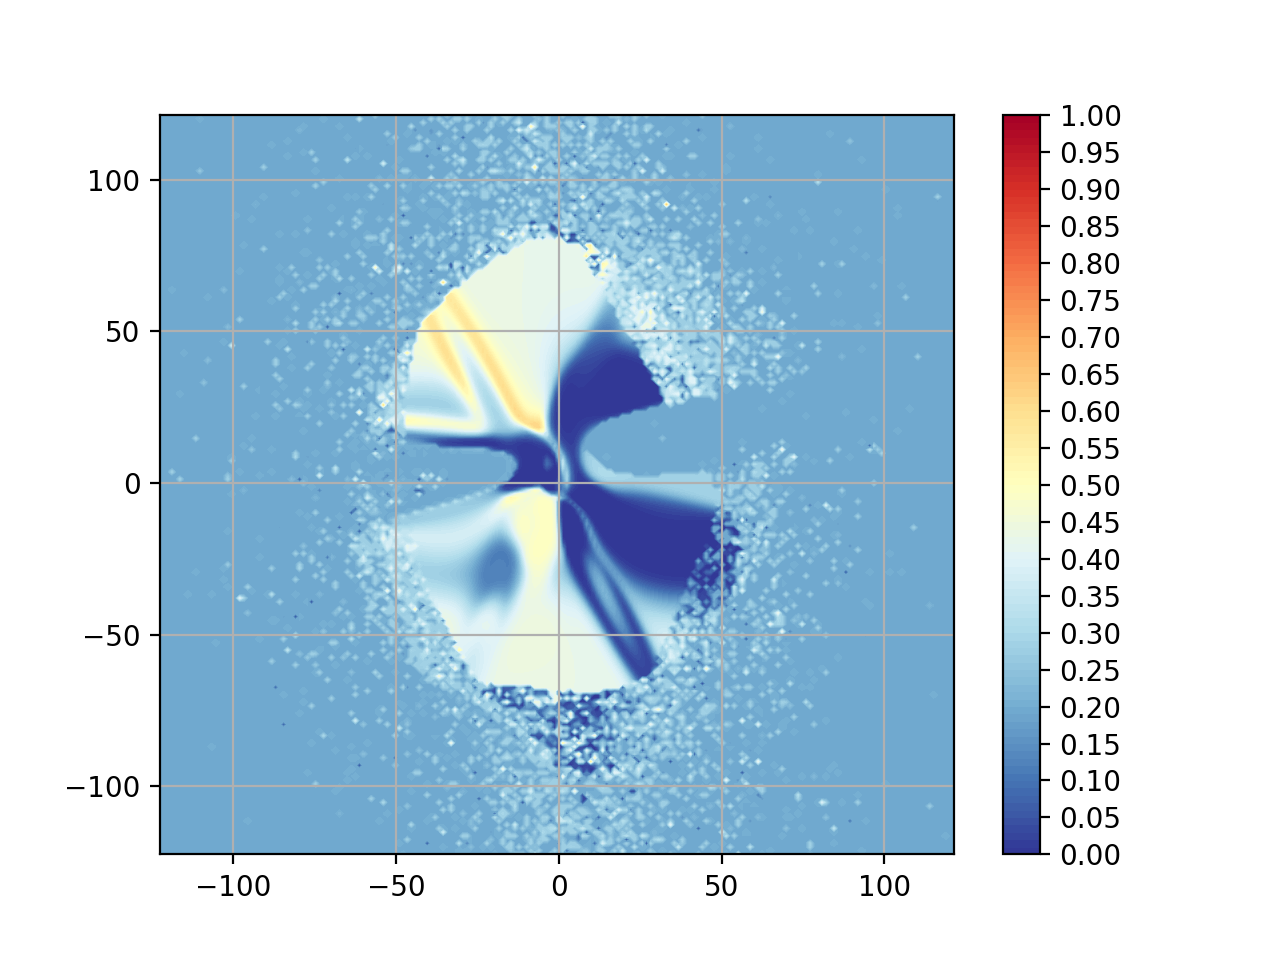

In [38]:
# plot the heatmaps individually
levels = np.arange(-0.0, 1.0+0.001, 10**(-2))
ticks = levels[::5]

for i in range(num_classes):
    plt.contourf(X1s, X2s, np.reshape(fgn_heatmap_preds_softmax[:,i], np.shape(X1s) ),levels=levels, cmap= mpl.cm.RdYlBu_r)
    plt.colorbar(ticks=ticks)
    plt.grid(True)
    plt.show()

<IPython.core.display.Javascript object>


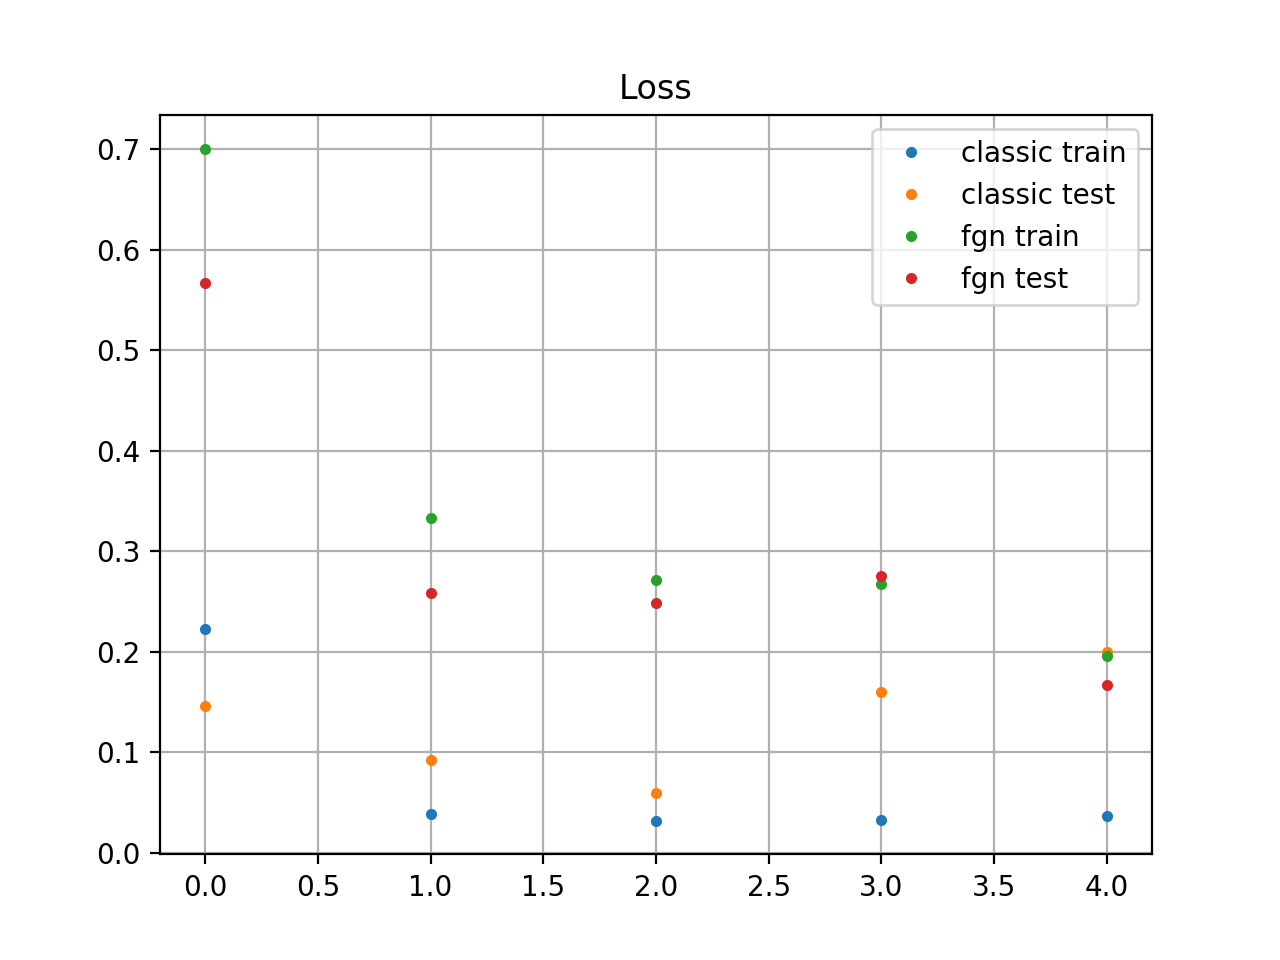

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


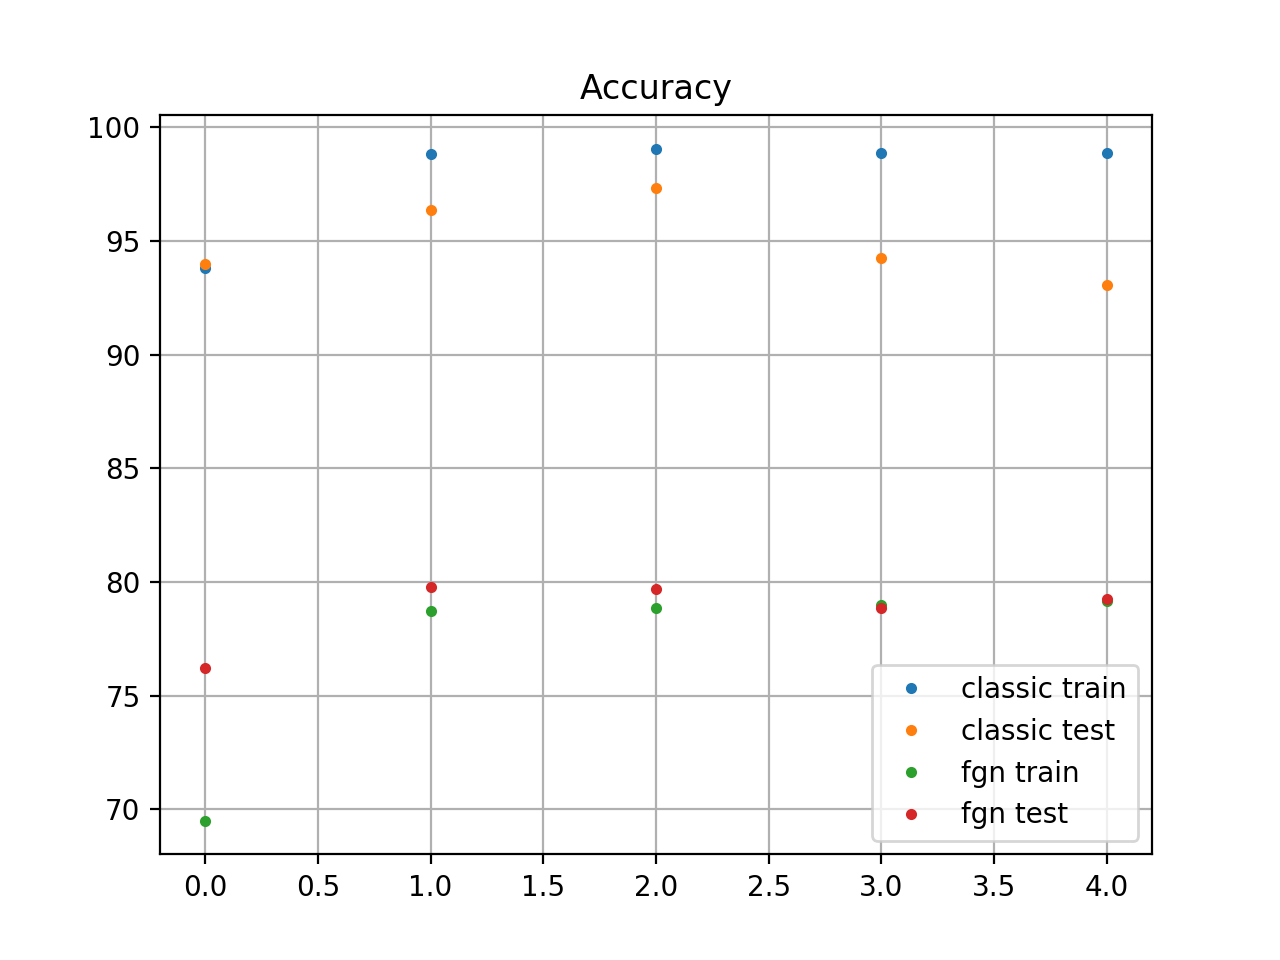

In [39]:
# acc and loss hist
plt.plot(classic_train_res['train_loss_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_loss_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_loss_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_loss_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(classic_train_res['train_acc_hist'], marker='.', linestyle=' ', label='classic train')
plt.plot(classic_train_res['test_acc_hist'], marker='.', linestyle=' ', label='classic test')
plt.plot(fgn_train_res['train_acc_hist'], marker='.', linestyle=' ', label='fgn train')
plt.plot(fgn_train_res['test_acc_hist'], marker='.', linestyle=' ', label='fgn test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [40]:
### plot some FGN param movement during training

fl.centers
plotting neurons: [2 4]


<IPython.core.display.Javascript object>


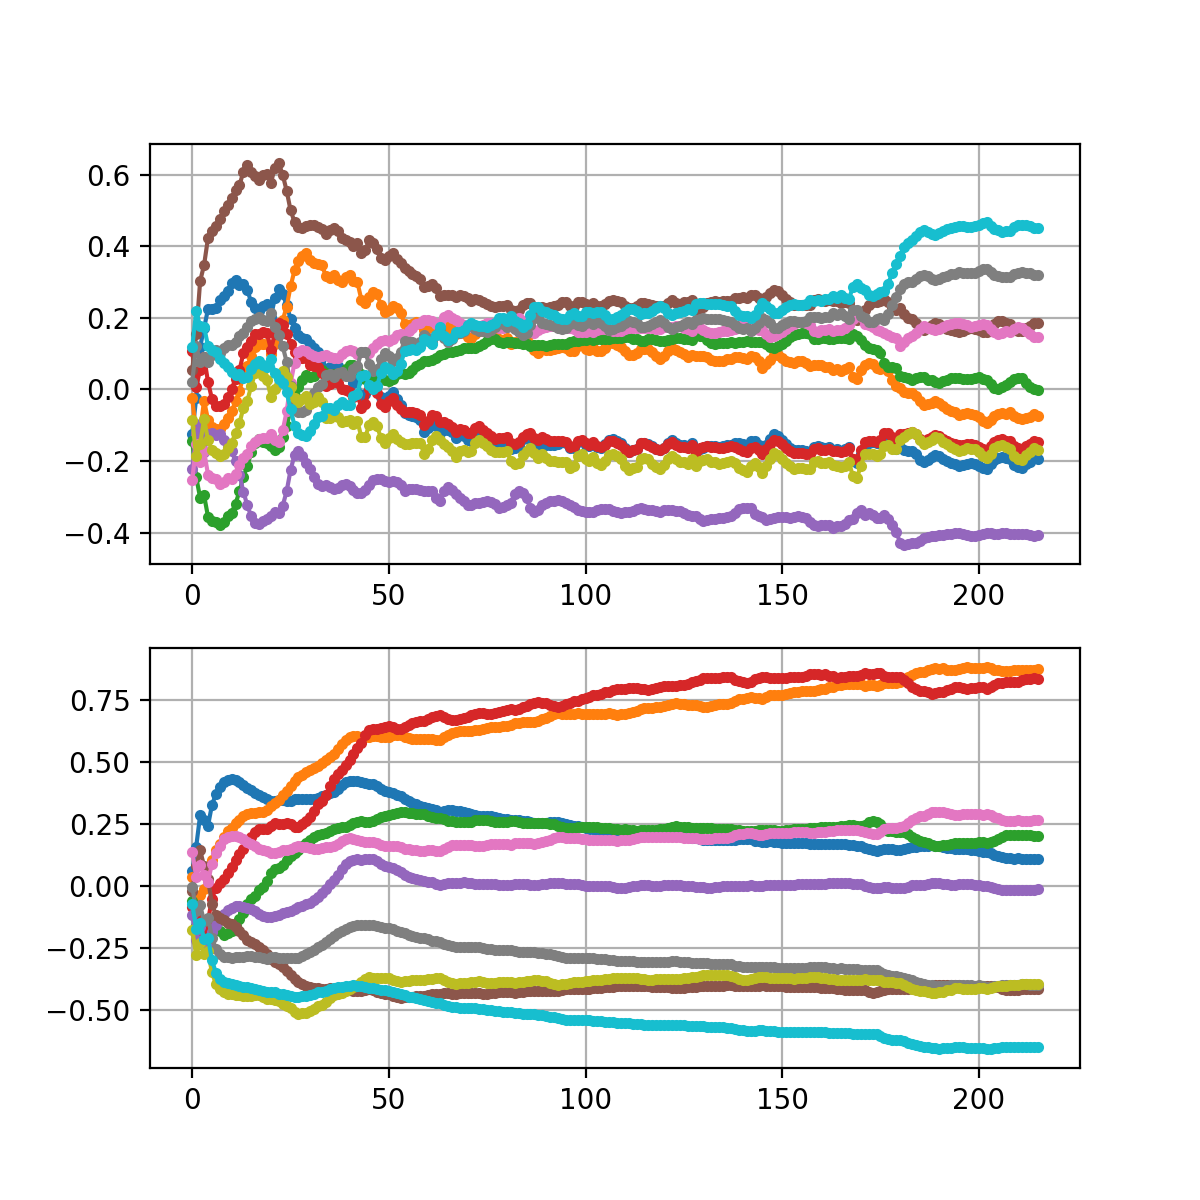

hidden_layers.2.centers
plotting neurons: [8 4]


<IPython.core.display.Javascript object>


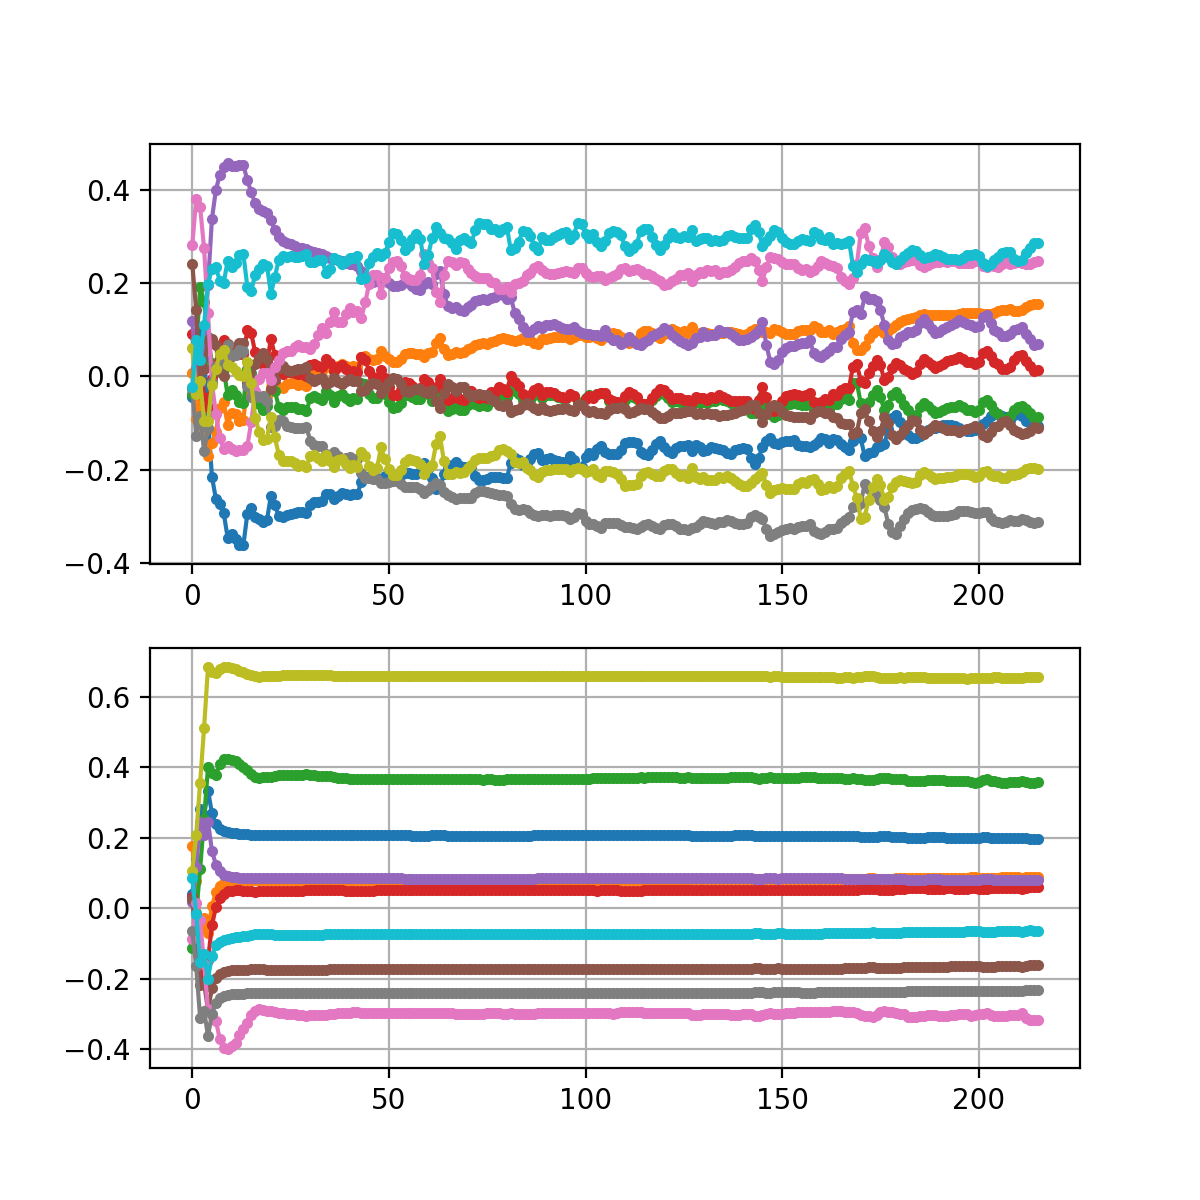

hidden_layers.0.centers
plotting neurons: [7 8]


<IPython.core.display.Javascript object>


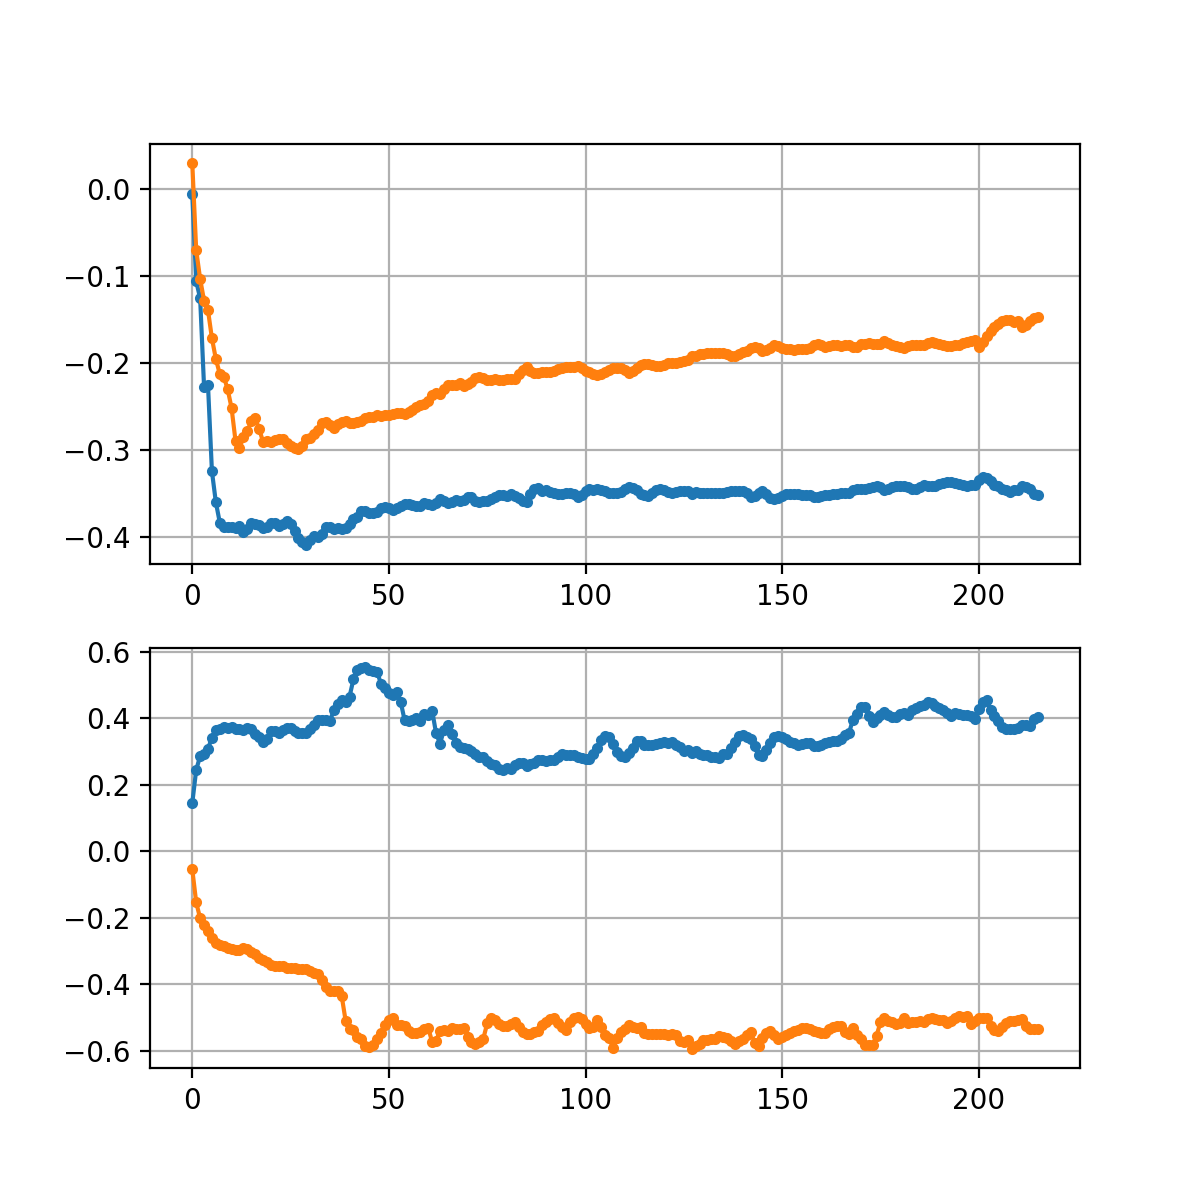

In [41]:
# plot centers history for only some hidden layer neuron
# for full FGN
for k in fgn_train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(fgn_train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = fgn_train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()

fl.inv_covar
(216, 5, 10, 10)


<IPython.core.display.Javascript object>


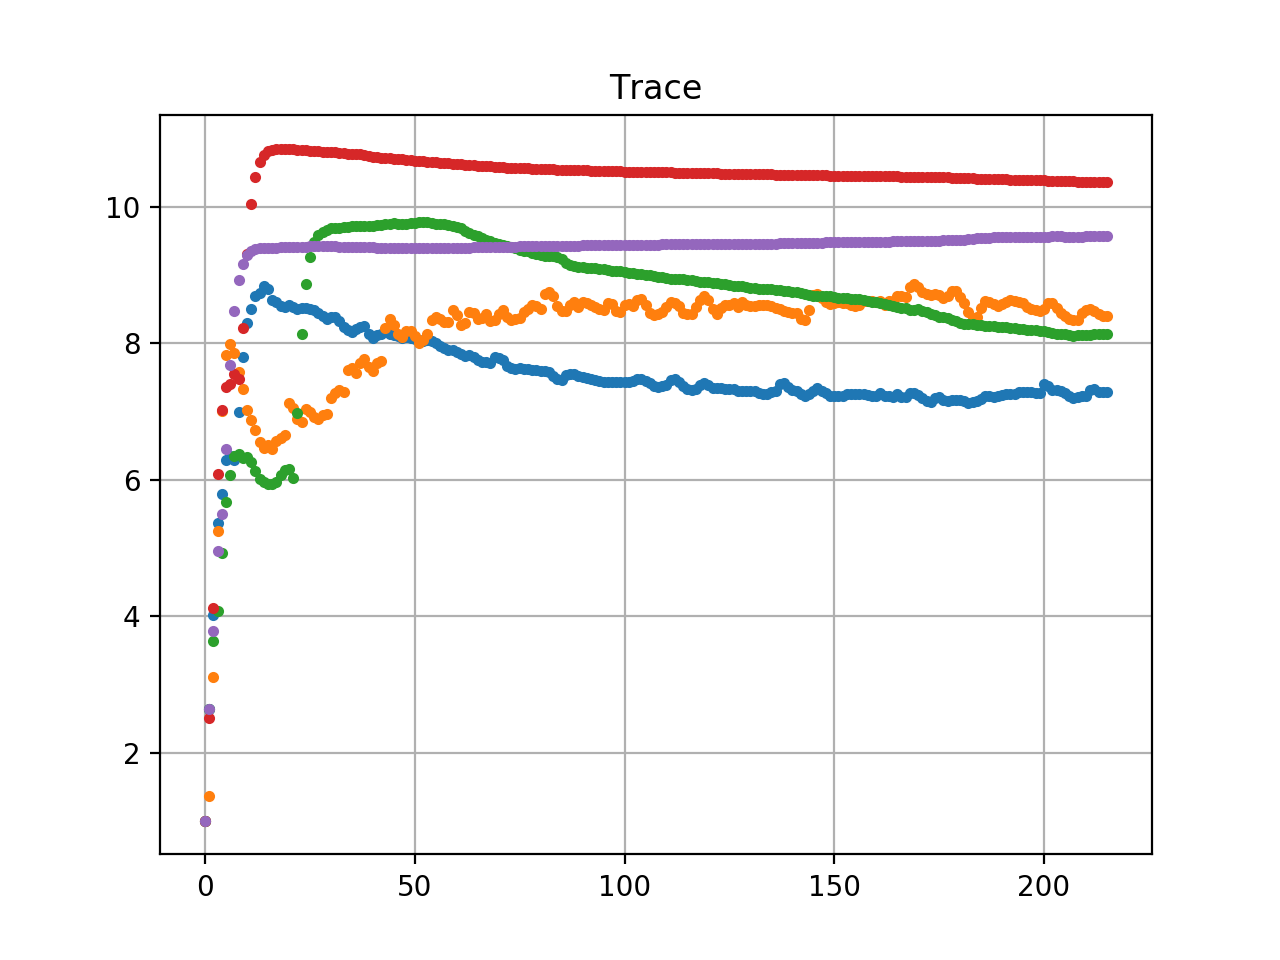

hidden_layers.2.inv_covar
(216, 10, 10, 10)


<IPython.core.display.Javascript object>


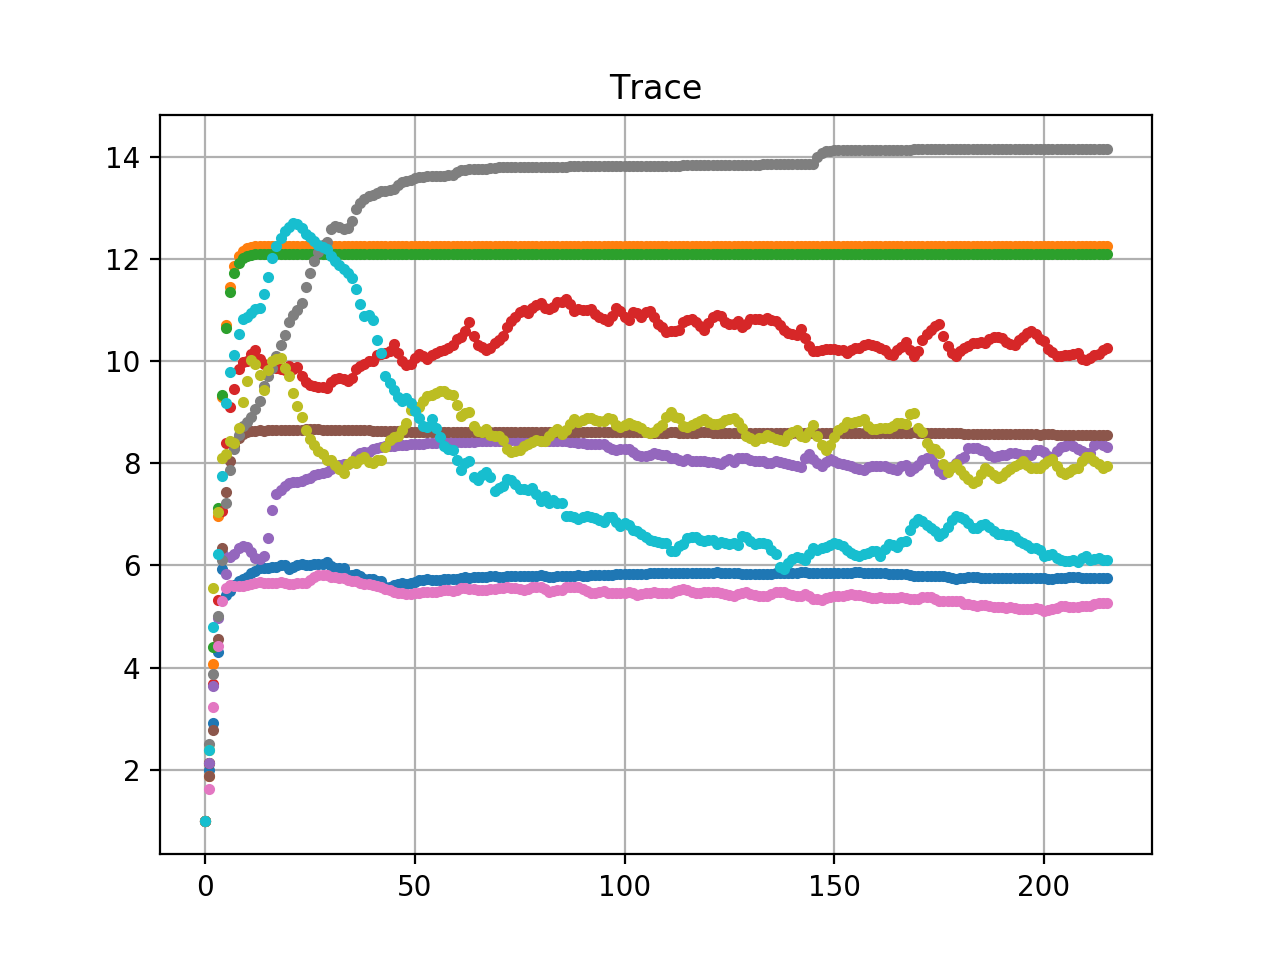

hidden_layers.0.inv_covar
(216, 10, 2, 2)


<IPython.core.display.Javascript object>


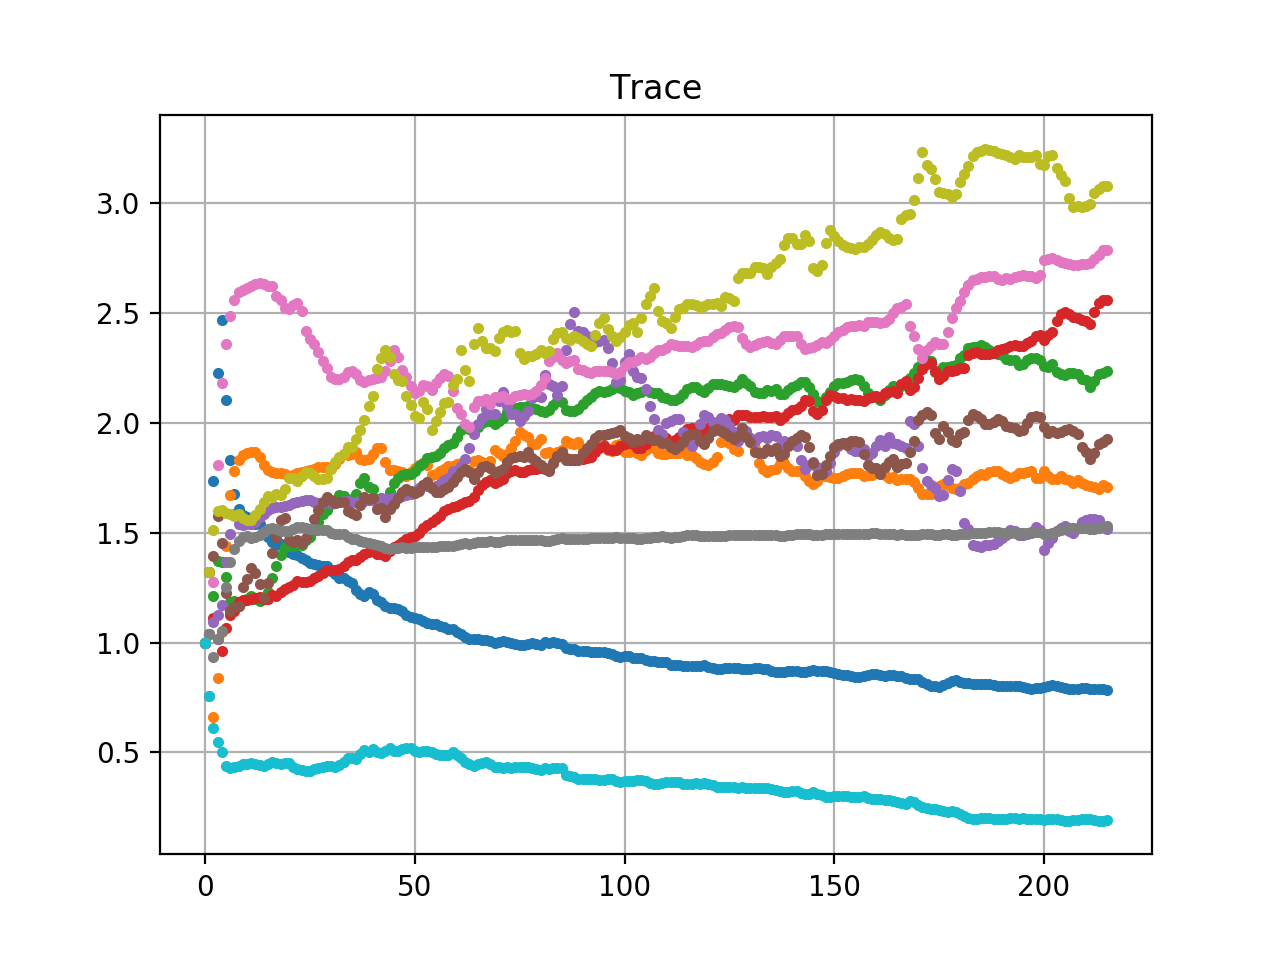

In [42]:
# check that inv covar has gone up, sigmas down, and trace down if covar_type=='full'
for k in fgn_train_res['histories'].keys():
    if 'inv_covar' in k:
        print(k)
        s = fgn_train_res['histories'][k].shape
        print(s)
        if covar_type == 'diag':
            # for each neuron
            for i in range(len(fgn_train_res['histories'][k][0])):
                plt.plot(fgn_train_res['histories'][k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Inverse Covariance')
                plt.grid()
                plt.show()
                
                plt.plot(1.0/fgn_train_res['histories'][k][:,i].reshape(s[0],np.prod(s[2:])), marker='.', linestyle=' ')
                plt.title('Sigmas')
                plt.grid()
                plt.show()
        
        elif covar_type == 'full':
            # plot trace of each neuron
            for i in range(len(fgn_train_res['histories'][k][0])):
                # plot trace
                trace = [np.einsum('ik,ik->', p, p) for p in fgn_train_res['histories'][k][:,i]]
                plt.plot(trace, marker='.', linestyle=' ')
            plt.title('Trace')
            plt.grid()
            plt.show()
        
        
        else:
            # covar_type == 'sphere'
            plt.plot(fgn_train_res['histories'][k], marker='.', linestyle=' ',)
            plt.title('Inverse Covariance')
            plt.grid()
            plt.show()
            
            plt.plot(1.0/fgn_train_res['histories'][k], marker='.', linestyle=' ')
            plt.title('Sigma')

            plt.grid()
            plt.show()

In [43]:
### Bonus adversarial attack

In [44]:
# # minimum/maximum pixel value post normalization
# min_v = -15.0
# max_v  = 15.0

In [45]:
# # FGSM attack code
# def fgsm_attack(image, epsilon, data_grad):
#     # Collect the element-wise sign of the data gradient
#     sign_data_grad = data_grad.sign()
#     # Create the perturbed image by adjusting each pixel of the input image
#     perturbed_image = image + epsilon*sign_data_grad
#     # Adding clipping to maintain range
#     perturbed_image = torch.clamp(perturbed_image, min_v, max_v)
#     # Return the perturbed image
#     return perturbed_image

In [46]:
# def test_under_attack( model, device, test_loader, epsilon ):

#     # Accuracy counter
#     correct = 0
#     adv_examples = []

#     # Loop over all examples in test set
#     for data, target in test_loader:

#         # Send the data and label to the device
#         data, target = data.to(device), target.to(device)

#         # Set requires_grad attribute of tensor. Important for Attack
#         data.requires_grad = True

#         # Forward pass the data through the model
#         output = model(data)
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

#         # If the initial prediction is wrong, dont bother attacking, just move on
#         if init_pred.item() != target.item():
#             continue

#         # Calculate the loss
#         loss = F.cross_entropy(output, target.long())

#         # Zero all existing gradients
#         model.zero_grad()

#         # Calculate gradients of model in backward pass
#         loss.backward()

#         # Collect datagrad
#         data_grad = data.grad.data

#         # Call FGSM Attack
#         perturbed_data = fgsm_attack(data, epsilon, data_grad)

#         # Re-classify the perturbed image
#         output = model(perturbed_data)

#         # Check for success
#         final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#         if final_pred.item() == target.item():
#             correct += 1
#             # Special case for saving 0 epsilon examples
#             if (epsilon == 0) and (len(adv_examples) < 5):
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save all adv examples for visualization later
#             adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#             adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

#     # Calculate final accuracy for this epsilon
#     final_acc = correct/float(len(test_loader))
#     print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

#     # Return the accuracy and an adversarial example
#     return final_acc, adv_examples

In [47]:
# batch_size = 1
# my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True) # create your dataloader
# my_test_dataloader = torch.utils.data.DataLoader(my_test_data, shuffle=True) # create your dataloader

In [48]:
# epsilons = np.arange(0, 10.01 ,0.5)
# print(epsilons)

In [49]:
# ### atack the FGN with non-random eval
# fgn_accuracies = []
# fgn_examples = []

# # set model to random eval
# fgn_model.set_random_eval(False)

# # Run test for each epsilon
# for eps in epsilons:
#     acc, ex = test_under_attack(fgn_model, device, my_dataloader, eps)
#     fgn_accuracies.append(acc)
#     fgn_examples.append(ex)

In [50]:
# ### atack the FGN with random eval
# fgn_random_eval_accuracies = []
# fgn_random_eval_examples = []

# # set model to random eval
# fgn_model.set_random_eval(True)

# # Run test for each epsilon
# for eps in epsilons:
#     acc, ex = test_under_attack(fgn_model, device, my_dataloader, eps)
#     fgn_random_eval_accuracies.append(acc)
#     fgn_random_eval_examples.append(ex)

In [51]:
# # attack the classic net
# classic_accuracies = []
# classic_examples = []

# # Run test for each epsilon
# for eps in epsilons:
#     acc, ex = test_under_attack(classic_model, device, my_dataloader, eps)
#     classic_accuracies.append(acc)
#     classic_examples.append(ex)

In [52]:
# # plot comparisons
# plt.plot(classic_accuracies, label='classic')
# plt.plot(fgn_accuracies, label='fgn')
# plt.title("Accuracy vs Epsilon")
# plt.xlabel("Epsilon")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()